In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import createXYPlot
from utils import getVariables
from datetime import datetime
from typing import List, Optional

In [2]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_incidence(df, split, age, colors, linestyles: Optional[List[str]] = None):
    createXYPlot(df,
             x="data",
             y=["no_vax_100k",
                "vax_100k",
                "1_dose_100k",
                "2_dosi_lt_cut_100k", 
                "2_dosi_gt_cut_100k", 
                "booster_100k"],
                colors=colors,
                error=True,
                alpha_err=0.1,
                labels=["non vaccinati",
                        "vaccinati",
                        "1 dose",
                        "2_dosi < 120gg",
                        "2_dosi > 120gg",
                        "booster"],
                plots_folder=plots_folder,
                linestyles=linestyles,
                title=f"Incidenza mensile {split} per 100k - dati ISS - {age}",
                figsize_x=10,
                figsize_y=5,
                dpis=90,
                linewidth=1.5,
                ytitle=f"N. {s} per 100k".replace("_"," "),
                savename=f"incidenza_{split}_{age}_per_100k",
                days_interval=1)

In [4]:
def plot_efficacy(df, age, split, 
                  start_date: Optional[str] = None,
                  cat: Optional[List[str]] = None, 
                  labels: Optional[List[str]] = None,
                  colors: Optional[List[str]] = None,
                  linestyles: Optional[List[str]] = None,
                  yticks: Optional[List[float]] = None,
                  suffix: str = ""
                 ):
    if cat == None:
        cat = ["vax"]
    y = [f"eff_{c}" for c in cat]
    if labels is None:
    
        labels = [l.replace("_"," ") for l in cat]
    createXYPlot(df,
                x="data",
                y=y,
                plots_folder=plots_folder,
                title=f"Efficacia mensile vs. {split} - {age}".replace("_"," "),
                labels=labels,
                colors=colors,
                linestyles=linestyles,
                error=True,
                figsize_x=10,
                figsize_y=5,
                start_date=start_date,
                yticks=yticks,
                dpis=90,
                linewidth=1.5,
                ytitle="[%]",
                savename=f"efficacia_{split}_{age}{suffix}",
                days_interval=1)

In [5]:
def plot_arr(df,
             age, 
             split, 
             start_date: Optional[str] = None,
             cat: Optional[List[str]] = None, 
             labels: Optional[List[str]] = None,
             colors: Optional[List[str]] = None,
             linestyles: Optional[List[str]] = None):
    
    if cat == None:
        cat == ["vax"]
    y = [f"arr_{c}" for c in cat]
    if labels is None:
        labels = [l.replace("_"," ") for l in cat]
        
    createXYPlot(df, x="data",
                 y=y,
                 plots_folder=plots_folder,
                 title=f"Riduzione rischio assoluto mensile {split} - {age}".replace("_"," "),
                 labels=labels,
                     linestyles=linestyles,
                     colors=colors,
                     start_date=start_date,
                     error=True,
                     figsize_x=10,
                     figsize_y=5,
                     dpis=90,
                     linewidth=1.5,
                     ytitle="[%]",
                     savename=f"arr_{split}_{age}",
                     days_interval=1)

### Iss data

In [6]:
df_ti = pd.read_csv("./data/rapporti_ISS - TI.csv")
df_decessi = pd.read_csv("./data/rapporti_ISS - Decessi.csv")
df_ricoveri = pd.read_csv("./data/rapporti_ISS - Ricoveri.csv")
df_contagi = pd.read_csv("./data/rapporti_ISS - Contagi.csv")
df_pop = pd.read_csv("./data/rapporti_ISS - Popolazione.csv")

In [7]:
cols_to_select = [x for x in df_pop.columns if "frac" not in x and x != "cut"]
df_pop = df_pop[cols_to_select]
df_pop["data"] = pd.to_datetime(df_pop["data"]).dt.date
df_pop = df_pop.rename(columns={"data":"data_pop"})

In [8]:
df_dict = {
    "contagi": df_contagi,
    "ricoveri": df_ricoveri,
    "terapie_intensive": df_ti, 
    "decessi": df_decessi
}

In [9]:
for d in df_dict.items():
    d[1]["split"] = d[0]

In [10]:
df_iss = pd.concat(df_dict.values()).reset_index(drop=True)
df_iss["tot"] = df_iss["vax"] + df_iss["no_vax"]
df_iss["data"] = pd.to_datetime(df_iss["data"]).dt.date

In [11]:
today = datetime.strftime(sorted(list(df_iss["data"].unique()))[-1],"%Y-%m-%d")

In [12]:
plots_folder = f"./plots/iss/{today}"
os.system(f"mkdir -p {plots_folder}")

0

In [13]:
# Set NaN Div by 0
for c in df_iss.columns:
    if "frac" not in c: 
        continue
    df_iss[c] = df_iss[c].apply(lambda x: np.nan if x == "#DIV/0!" else x).astype(float)

In [14]:
age_values = df_iss["fascia_eta"].unique()
splits = df_iss["split"].unique()

In [15]:
from datetime import timedelta
df_iss["data_pop"] = df_iss["data"].apply(lambda x: x - timedelta(14))

In [16]:
df_iss = df_iss.merge(df_pop, on=["data_pop","fascia_eta"], how="left", suffixes=("","_pop"))

In [17]:
df_iss[(df_iss.split=="ricoveri")][["data","fascia_eta","no_vax","no_vax_pop","vax","vax_pop"]]

data fascia_eta   no_vax  no_vax_pop      vax     vax_pop
162  2021-10-24      12-39    475.0         NaN    119.0         NaN
163  2021-10-24      40-59    991.0         NaN    284.0         NaN
164  2021-10-24      60-79    985.0         NaN    958.0         NaN
165  2021-10-24        80+    439.0         NaN   1192.0         NaN
166  2021-10-24     totale   2890.0         NaN   2523.0         NaN
167  2021-10-31      12-39    476.0         NaN    158.0         NaN
168  2021-10-31      40-59   1055.0         NaN    379.0         NaN
169  2021-10-31      60-79   1181.0         NaN   1155.0         NaN
170  2021-10-31        80+    508.0         NaN   1404.0         NaN
171  2021-10-31     totale   3220.0         NaN   3096.0         NaN
172  2021-11-07      12-39    505.0   3649047.0    180.0  13786508.0
173  2021-11-07      40-59   1251.0   3102638.0    446.0  15334867.0
174  2021-11-07      60-79   1369.0   1318627.0   1556.0  12254152.0
175  2021-11-07        80+    612.0    232553.0   1693.0   4331550.0
176  2021-11-07     totale   3737.0   8302865.0   3875.0  45707077.0
177  2021-11-14      12-39    496.0   3423613.0    194.0  14011942.0
178  2021-11-14      40-59   1264.0   2932766.0    481.0  15504739.0
179  2021-11-14      60-79   1374.0   1278622.0   1623.0  12294157.0
180  2021-11-14        80+    599.0    227566.0   1764.0   4336537.0
181  2021-11-14     totale   3733.0   7862567.0   4062.0  46147375.0
182  2021-11-21      12-39    540.0   3271713.0    227.0  14163842.0
183  2021-11-21      40-59   1462.0   2832244.0    591.0  15601007.0
184  2021-11-21      60-79   1672.0   1254000.0   2044.0  12318779.0
185  2021-11-21        80+    728.0    228056.0   2038.0   4340303.0
186  2021-11-21     totale   4402.0   7586013.0   4900.0  46423931.0
187  2021-11-28      12-39    586.0   3180652.0    261.0  14254903.0
188  2021-11-28      40-59   1691.0   2773086.0    688.0  15660165.0
189  2021-11-28      60-79   1957.0   1229843.0   2457.0  12342936.0
190  2021-11-28        80+    847.0    221018.0   2329.0   4347341.0
191  2021-11-28     totale   5081.0   7404599.0   5735.0  46605345.0
192  2021-12-05      12-39    602.0   3117673.0    318.0  14317882.0
193  2021-12-05      40-59   1997.0   2738676.0    777.0  15694575.0
194  2021-12-05      60-79   2321.0   1216945.0   2988.0  12355834.0
195  2021-12-05        80+   1024.0    218428.0   2617.0   4349931.0
196  2021-12-05     totale   5944.0   7291722.0   6700.0  46718222.0
197  2021-12-12      12-39    684.0   3046339.0    361.0  14389216.0
198  2021-12-12      40-59   2350.0   2698233.0    879.0  15733843.0
199  2021-12-12      60-79   2794.0   1199938.0   3478.0  12372666.0
200  2021-12-12        80+   1231.0    216424.0   2869.0   4353285.0
201  2021-12-12     totale   7059.0   7160934.0   7587.0  46849010.0
202  2021-12-19      12-39    808.0   2975787.0    467.0  14459768.0
203  2021-12-19      40-59   2691.0   2660294.0   1031.0  15771782.0
204  2021-12-19      60-79   3262.0   1182593.0   3876.0  12390011.0
205  2021-12-19        80+   1517.0    212977.0   3099.0   4356732.0
206  2021-12-19     totale   8278.0   7031651.0   8473.0  46978293.0
207  2021-12-26      12-39    949.0   2892447.0    889.0  14543818.0
208  2021-12-26      40-59   3047.0   2613841.0   1330.0  15817761.0
209  2021-12-26      60-79   3805.0   1161325.0   4489.0  12410683.0
210  2021-12-26        80+   1763.0    209075.0   3375.0   4360995.0
211  2021-12-26     totale   9564.0   6876688.0  10083.0  47133257.0
212  2022-01-02      12-39   1305.0   2765891.0   1764.0  14670374.0
213  2022-01-02      40-59   3520.0   2553007.0   2127.0  15878595.0
214  2022-01-02      60-79   4547.0   1136914.0   5569.0  12435094.0
215  2022-01-02        80+   2115.0    204451.0   4221.0   4365619.0
216  2022-01-02     totale  11487.0   6660263.0  13681.0  47349682.0
217  2022-01-09      12-39   1760.0   2618486.0   2837.0  14817452.0
218  2022-01-09      40-59   3875.0   2481703.0   3166.0  15946577.0
219  2022

### Incidence

In [18]:
vnames = ["no_vax", "vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut", "booster"]
for v in vnames:
    df_iss[f"{v}_100k"] = 1e5 * df_iss[v]/df_iss[f"{v}_pop"]
    df_iss[f"{v}_100k_sd"] = 1e5 * np.sqrt((df_iss[v]/df_iss[f"{v}_pop"]) * (1 - df_iss[v]/df_iss[f"{v}_pop"]) / df_iss[f"{v}_pop"])
    df_iss[f"err_{v}_100k"] = 1.645 * df_iss[f"{v}_100k_sd"]
    if v != "no_vax":
        df_iss[f"eff_{v}"] = 100 * (1 - df_iss[f"{v}_100k"]/df_iss[f"no_vax_100k"])
        df_iss[f"eff_{v}_sd"] = 100 * np.sqrt((df_iss[f"no_vax_100k"]**-2 * df_iss[f"{v}_100k_sd"]**2 + 
                                              df_iss[f"no_vax_100k"]**-4 * df_iss[f"{v}_100k"]**2 * df_iss[f"no_vax_100k_sd"]**2))
        df_iss[f"err_eff_{v}"] = 1.645 * df_iss[f"eff_{v}_sd"]
        df_iss[f"arr_{v}"] = (df_iss[f"no_vax_100k"] - df_iss[f"{v}_100k"]) / 1000
        df_iss[f"err_arr_{v}"] = 1.645 * np.sqrt(df_iss[f"no_vax_100k_sd"]**2 + df_iss[f"{v}_100k_sd"]**2) / 1000
        
        df_iss[f"err_eff_{v}"] = np.where(df_iss[f"err_eff_{v}"] + df_iss[f"eff_{v}"] > 100, 100 - df_iss[f"eff_{v}"], df_iss[f"err_eff_{v}"])

In [19]:
df_iss[df_iss.split=="terapie_intensive"][["fascia_eta","eff_vax","err_eff_vax"]]

fascia_eta     eff_vax  err_eff_vax
324      12-39         NaN          NaN
325      40-59         NaN          NaN
326      60-79         NaN          NaN
327        80+         NaN          NaN
328     totale         NaN          NaN
329      12-39         NaN          NaN
330      40-59         NaN          NaN
331      60-79         NaN          NaN
332        80+         NaN          NaN
333     totale         NaN          NaN
334      12-39  100.000000     0.000000
335      40-59   96.561785     1.199751
336      60-79   93.428056     1.016988
337        80+   88.341997     3.917303
338     totale   89.864502     1.234878
339      12-39  100.000000     0.000000
340      40-59   97.019409     1.034557
341      60-79   93.720609     0.944022
342        80+   88.831938     3.566364
343     totale   90.607284     1.109208
344      12-39   97.112619     2.887381
345      40-59   96.690634     1.000544
346      60-79   93.005093     0.952861
347        80+   89.371823     3.221808
348     totale   90.137386     1.063747
349      12-39   93.388833     4.377747
350      40-59   96.458420     0.902536
351      60-79   93.152741     0.859081
352        80+   91.632614     2.518793
353     totale   90.918176     0.906337
354      12-39   95.083137     3.384663
355      40-59   96.648709     0.790328
356      60-79   93.255901     0.779721
357        80+   92.288544     2.178050
358     totale   91.342644     0.800531
359      12-39   94.571542     3.165246
360      40-59   96.846119     0.705627
361      60-79   93.017892     0.735788
362        80+   93.025046     1.834331
363     totale   91.339408     0.735971
364      12-39   94.426312     2.866687
365      40-59   96.693482     0.669249
366      60-79   93.693916     0.635777
367        80+   93.382698     1.584918
368     totale   91.968155     0.644863
369      12-39   92.897210     3.043626
370      40-59   96.575959     0.645200
371      60-79   94.232357     0.549351
372        80+   93.700639     1.482680
373     totale   92.459760     0.574501
374      12-39   91.223332     3.363624
375      40-59   95.898395     0.676074
376      60-79   94.358281     0.496854
377        80+   92.901243     1.543265
378     totale   92.230660     0.542968
379      12-39   88.402990     3.788330
380      40-59   94.890326     0.732284
381      60-79   94.112516     0.475367
382        80+   93.277273     1.353500
383     totale   91.781536     0.524602
384      12-39   89.357351     3.199296
385      40-59   93.567653     0.853823
386      60-79   93.816766     0.480834
387        80+   93.157767     1.282758
388     totale   91.122449     0.540960
389      12-39   82.289048     5.155932
390      40-59   92.037143     1.039935
391      60-79   93.116607     0.521965
392        80+   92.246435     1.391520
393     totale   89.794890     0.607933
394      12-39   81.896203     5.280640
395      40-59   89.979581     1.338518
396      60-79   92.494150     0.585149
397        80+   92.941245     1.205614
398     totale   88.646258     0.690851
399      12-39   82.441230     5.318346
400      40-59   87.708858     1.748267
401      60-79   92.435896     0.624158
402        80+   91.495216     1.521097
403     totale   87.460469     0.805784
404      12-39   78.875244     6.994966
405      40-59   85.538734     2.410264
406      60-79   91.383631     0.788678
407        80+   91.187359     1.679897
408     totale   85.781348     1.020671
409      12-39   79.042479     7.911697
410      40-59   83.795131     3.132159
411      60-79   91.535654     0.869443
412        80+   90.552198     1.931846
413     totale   85.125000     1.196169
414      05-11  100.000000     0.000000
415      12-39   82.124586     7.700019
416      40-59   78.900354     4.736257
417      60-79   91.209923     1.000504
418        80+   88.499854     2.707320
419     totale   83.551154     1.484097
420      05-11  100.000000     0.000000
421      12-39   75.223560    12.888534
422      40-59   77.148767     5.835462
423 

contagi 12-39


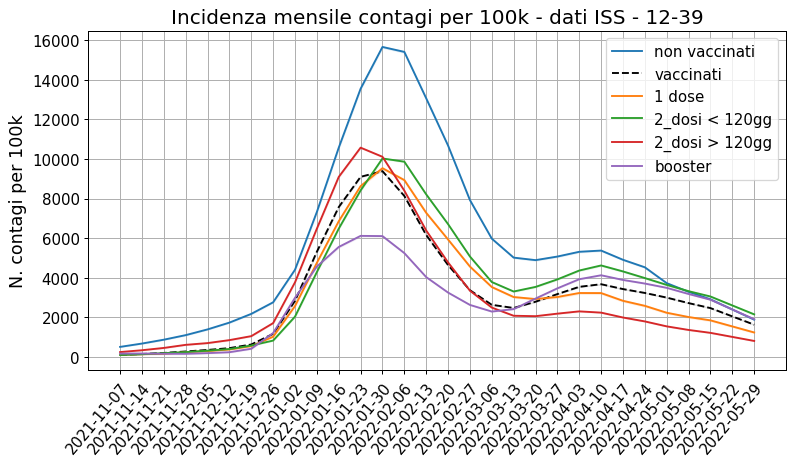

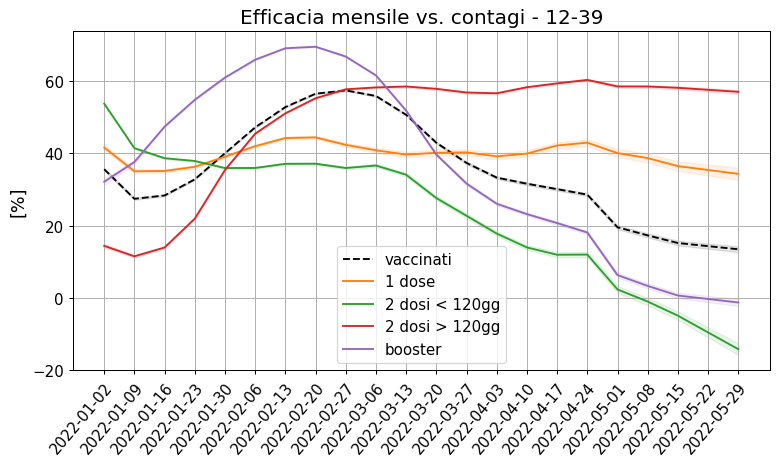

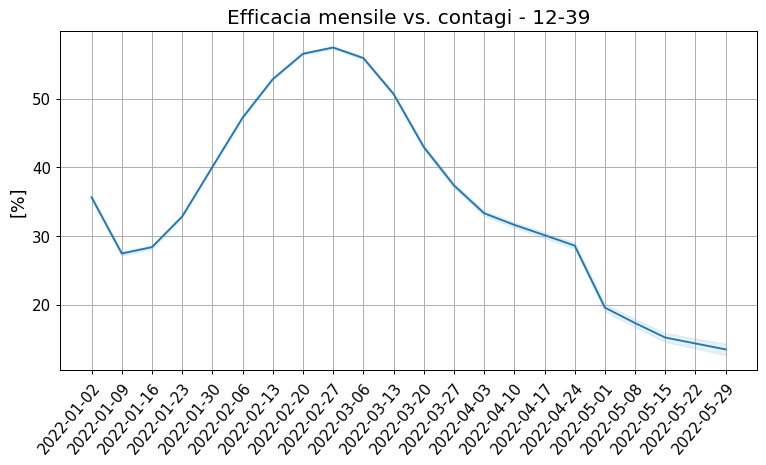

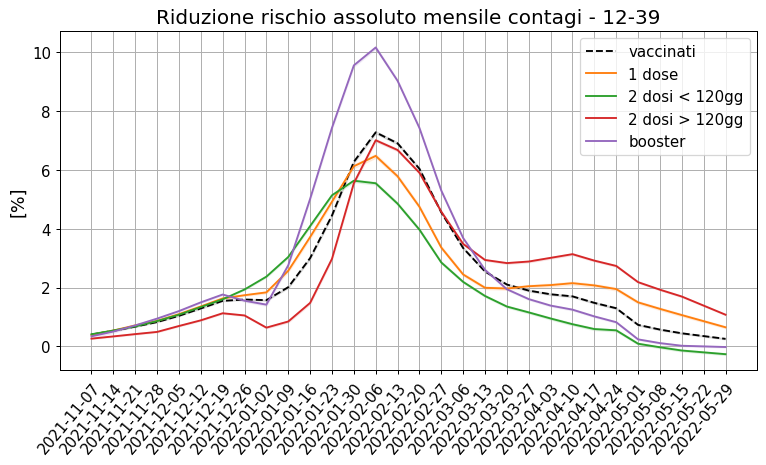

contagi 40-59


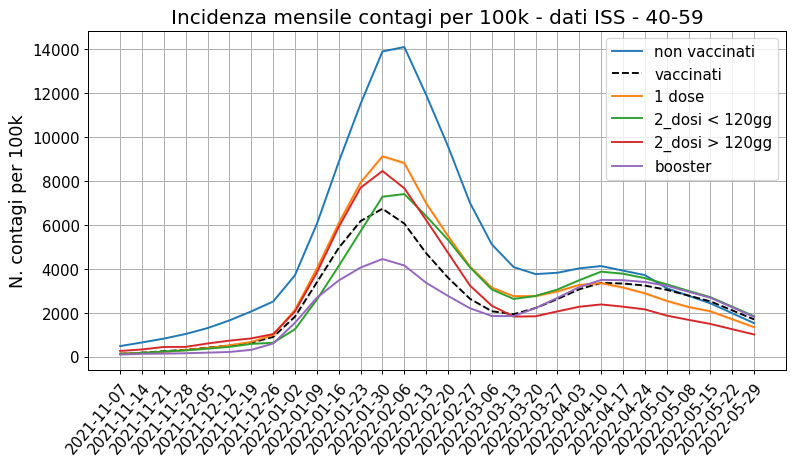

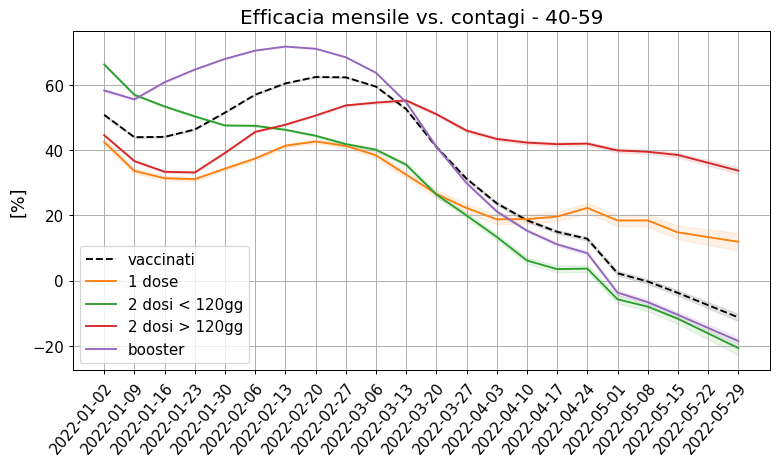

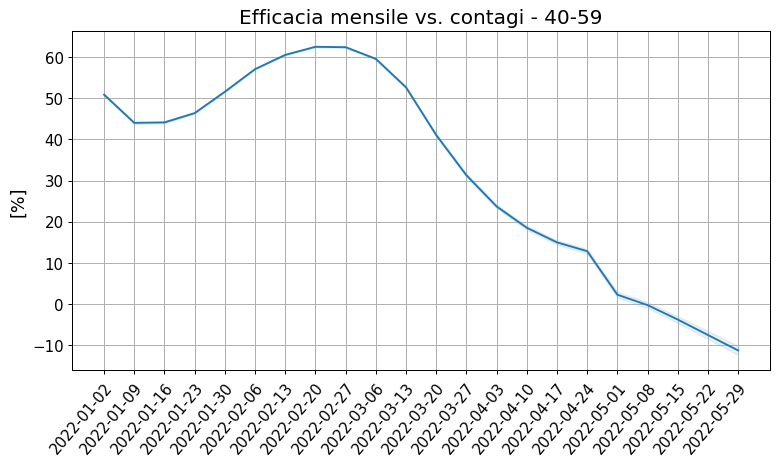

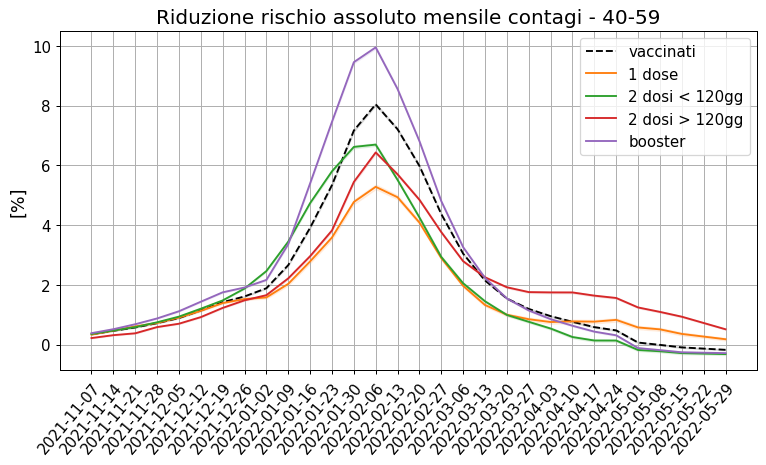

contagi 60-79


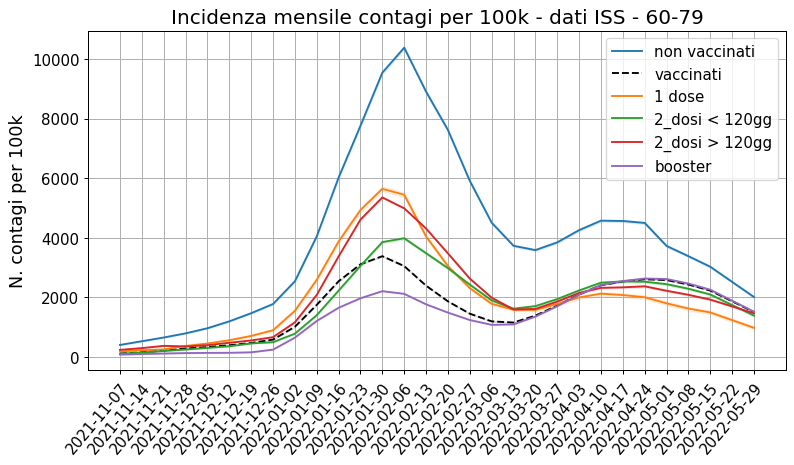

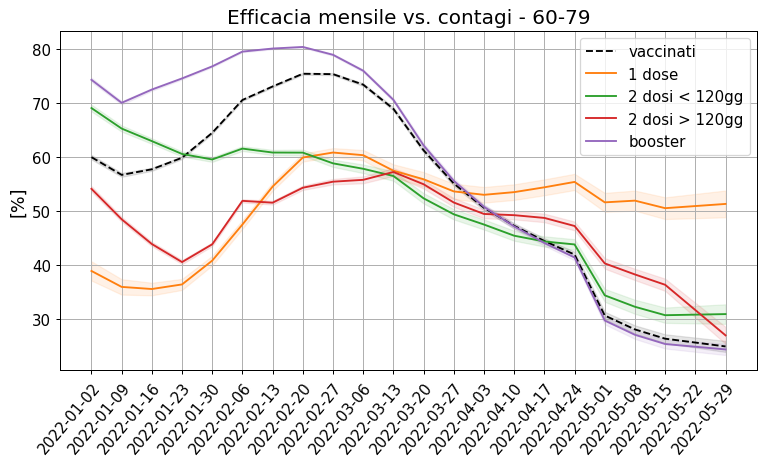

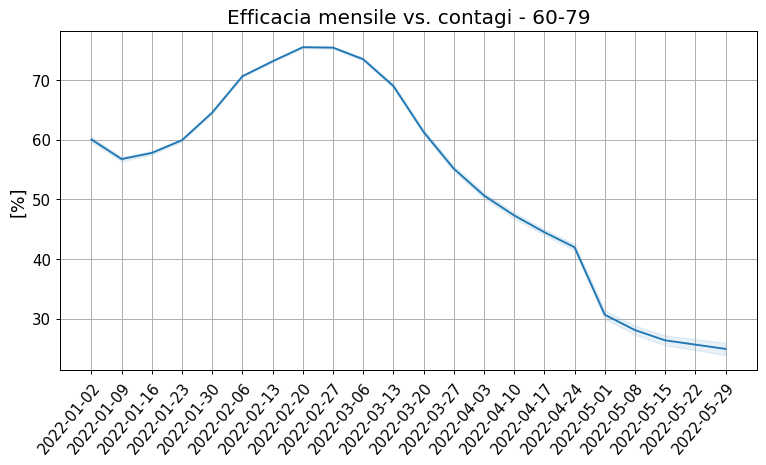

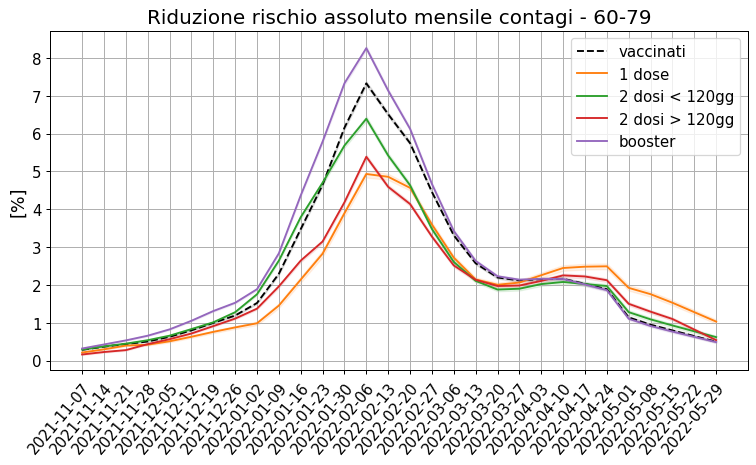

contagi 80+


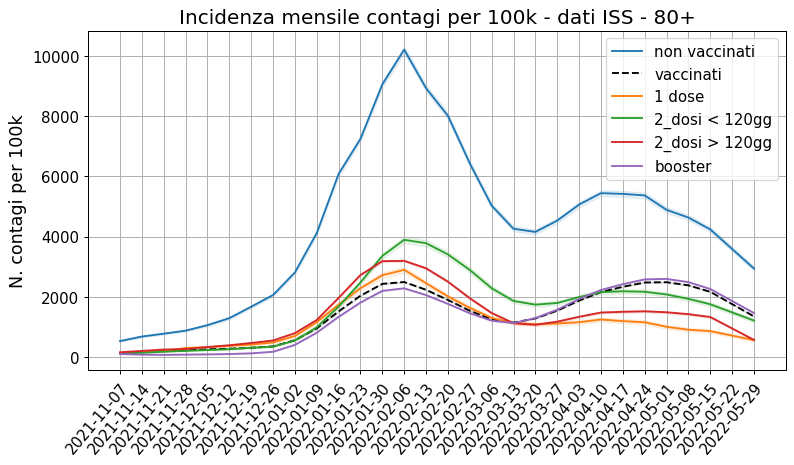

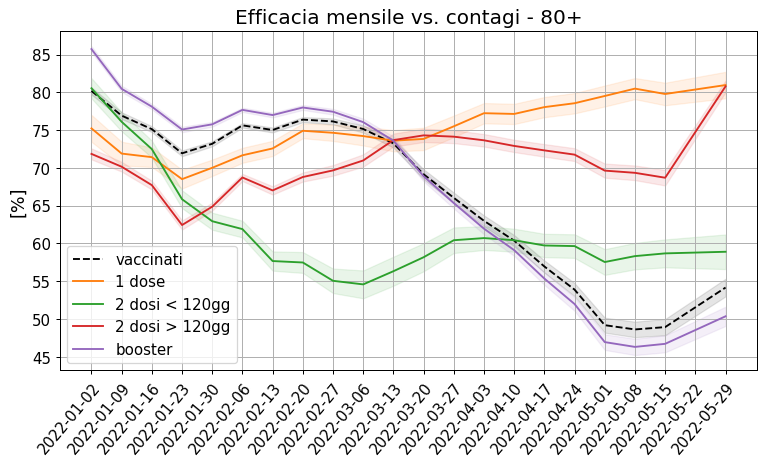

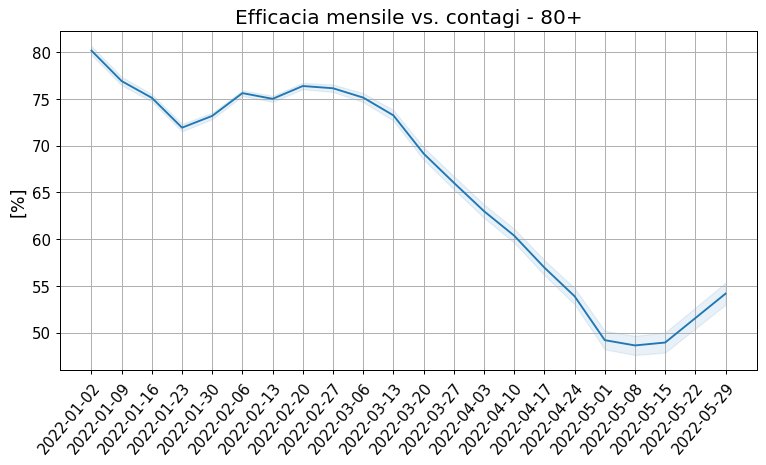

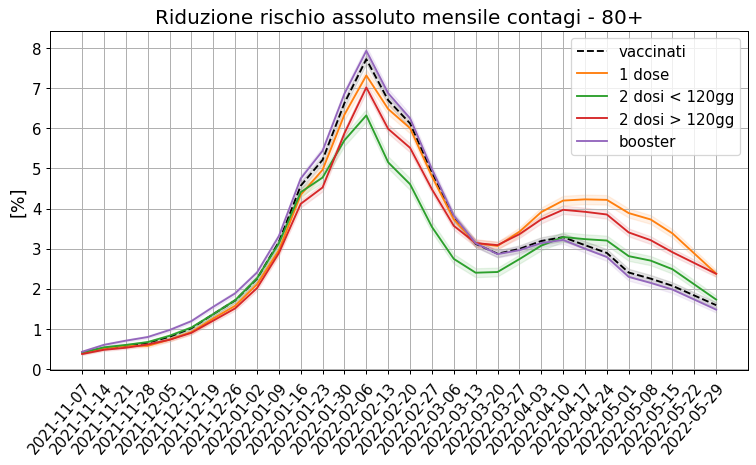

contagi totale


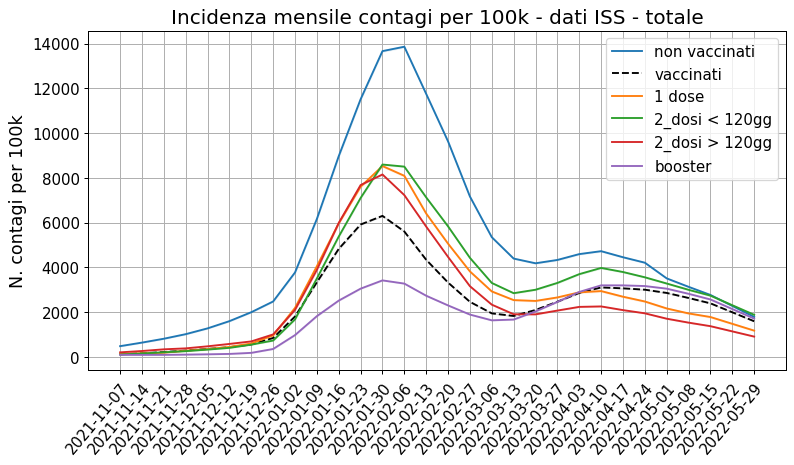

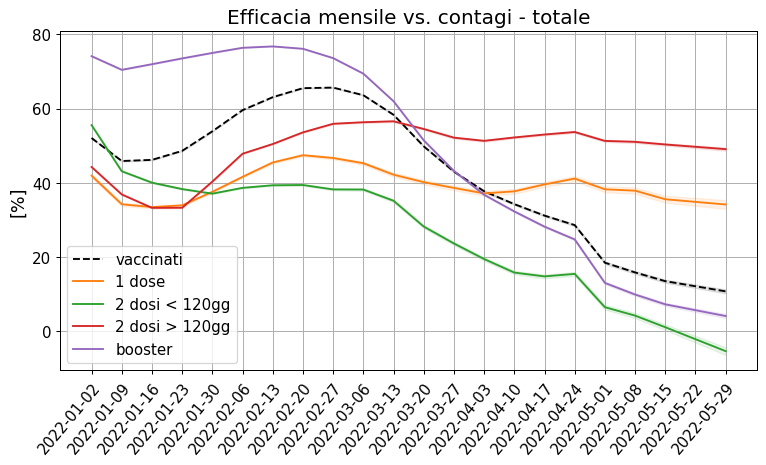

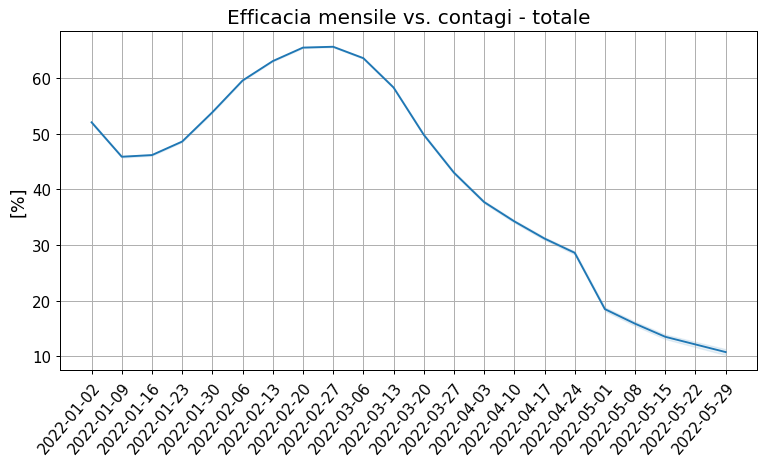

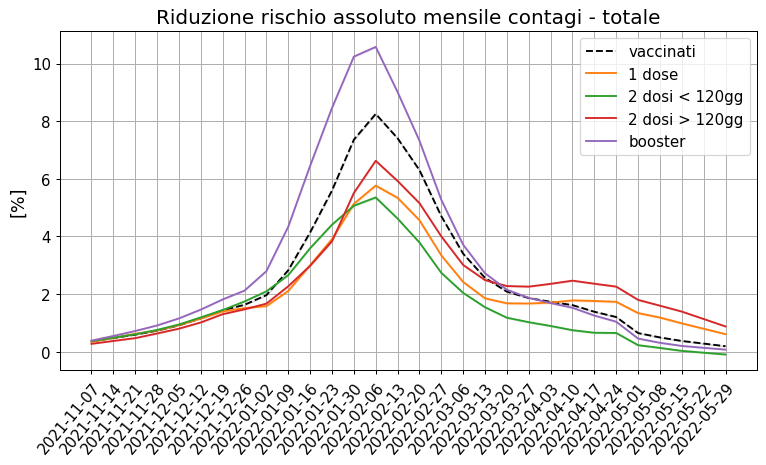

contagi 05-11


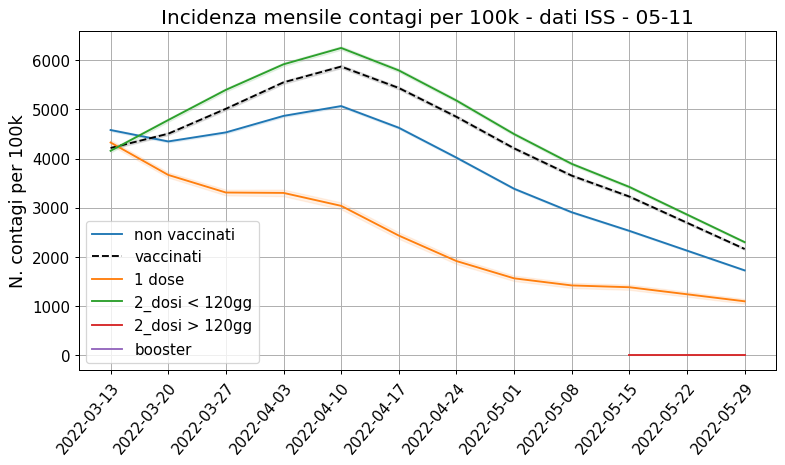

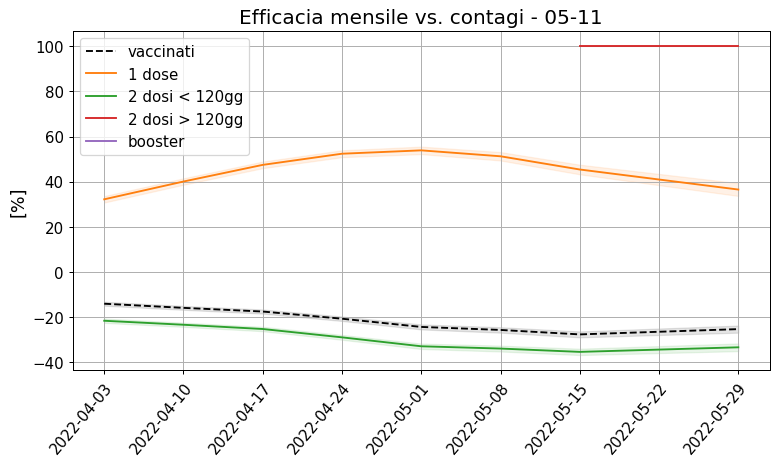

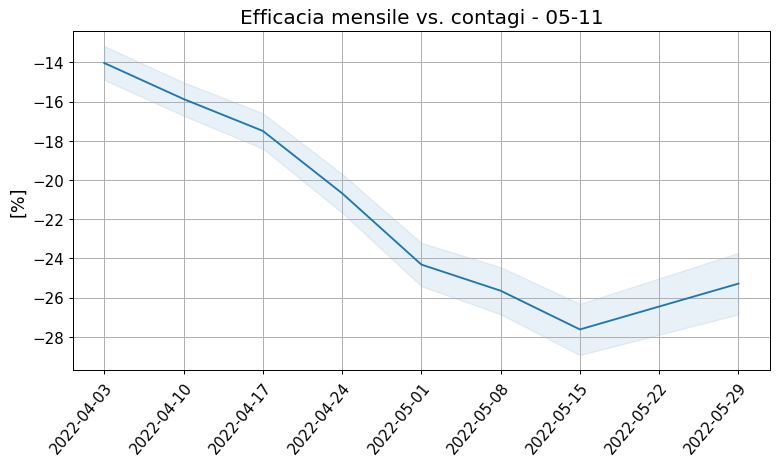

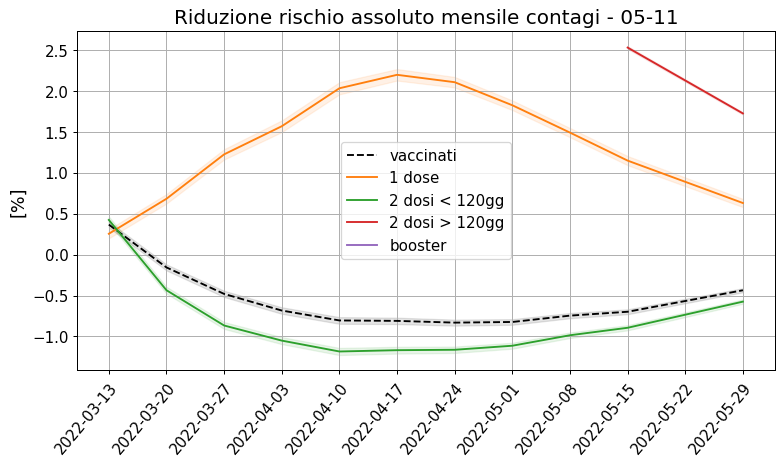

ricoveri 12-39


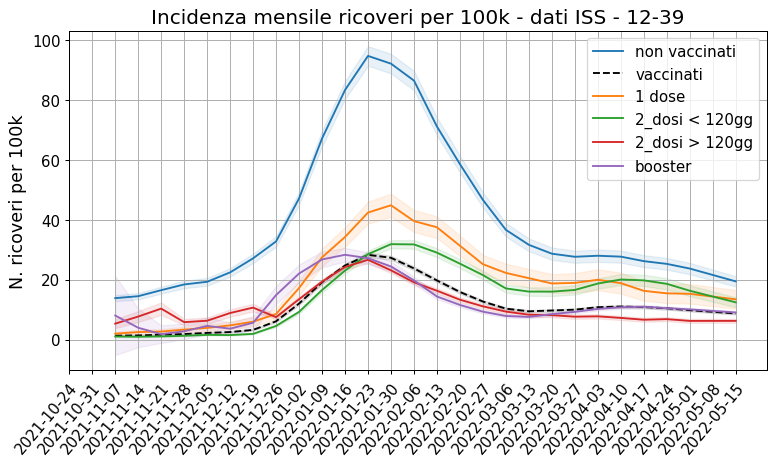

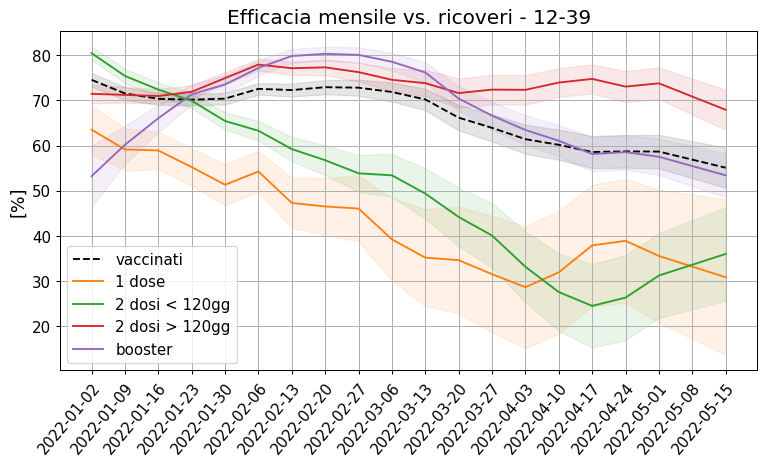

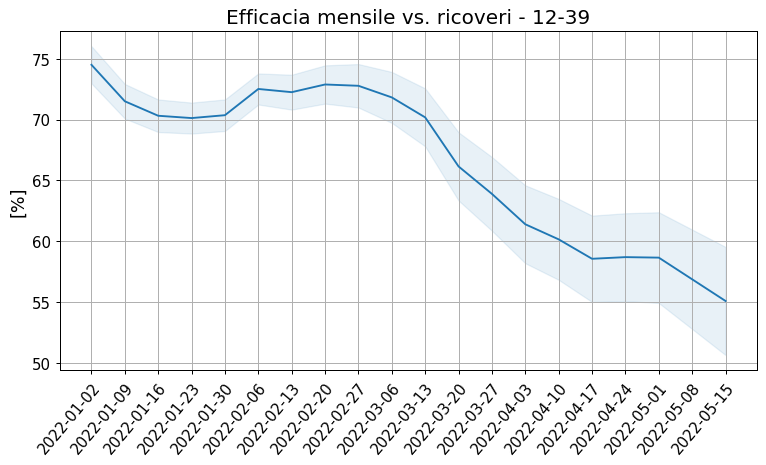

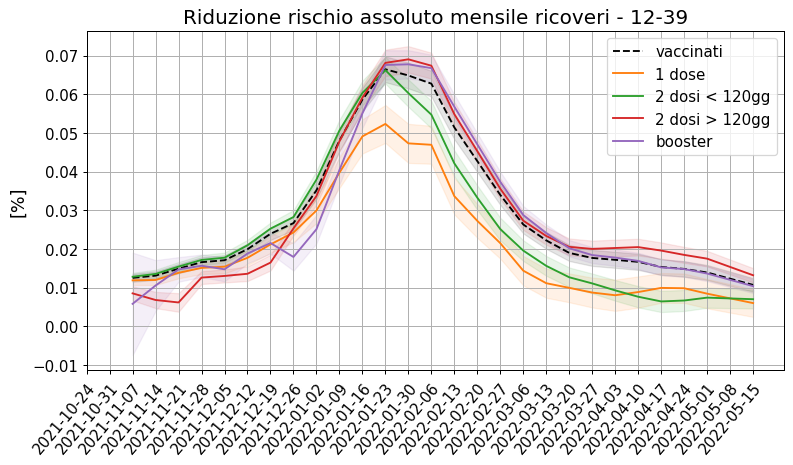

ricoveri 40-59


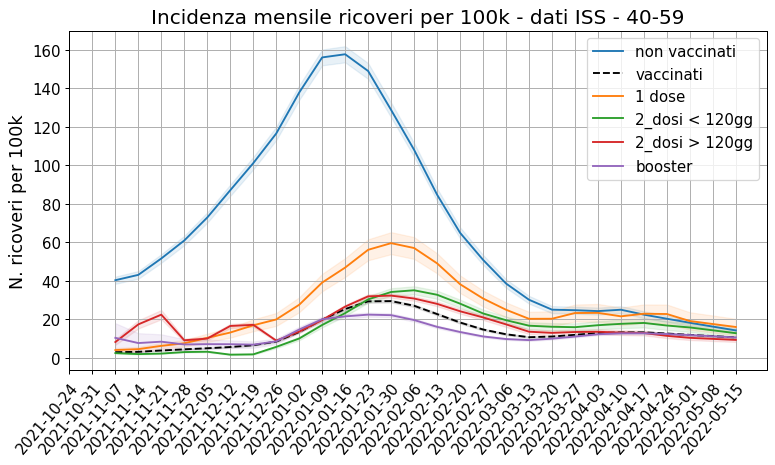

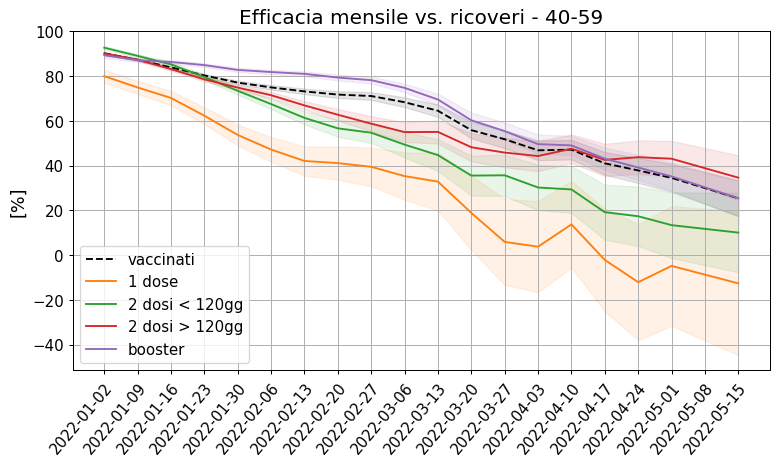

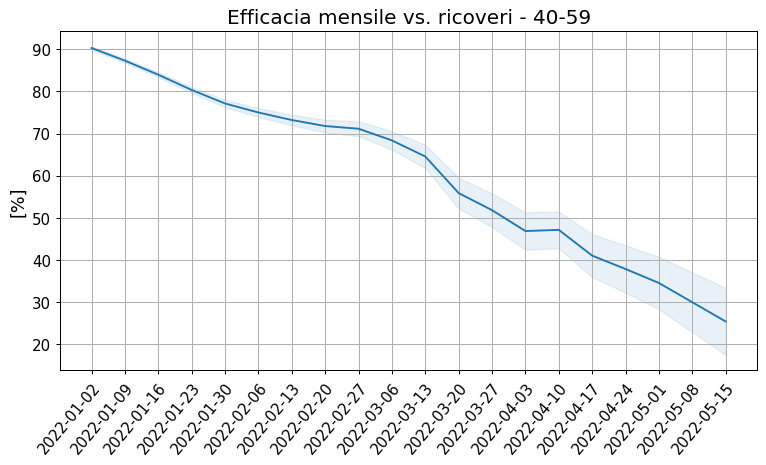

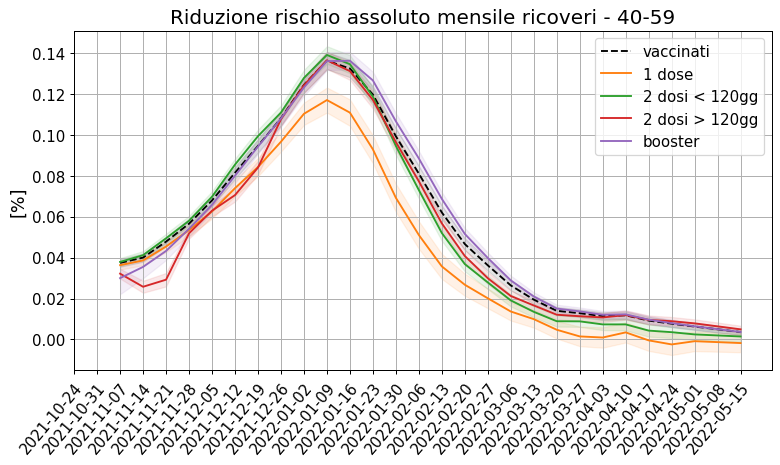

ricoveri 60-79


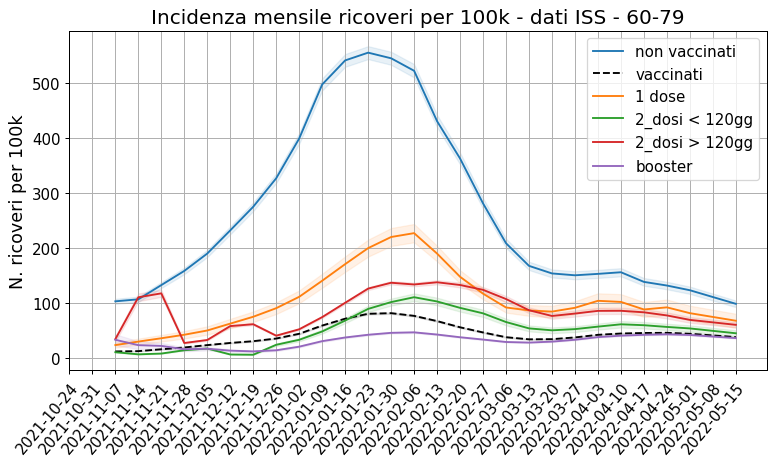

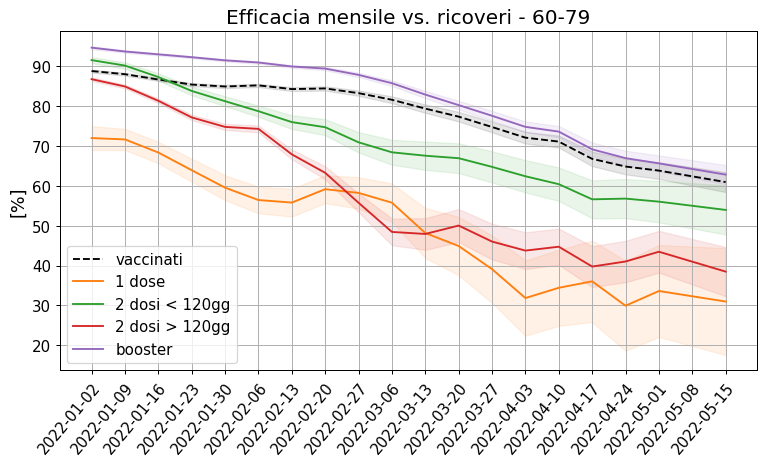

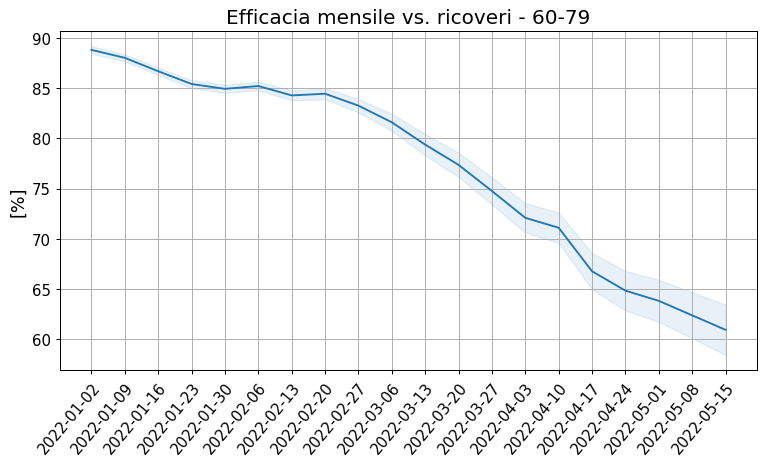

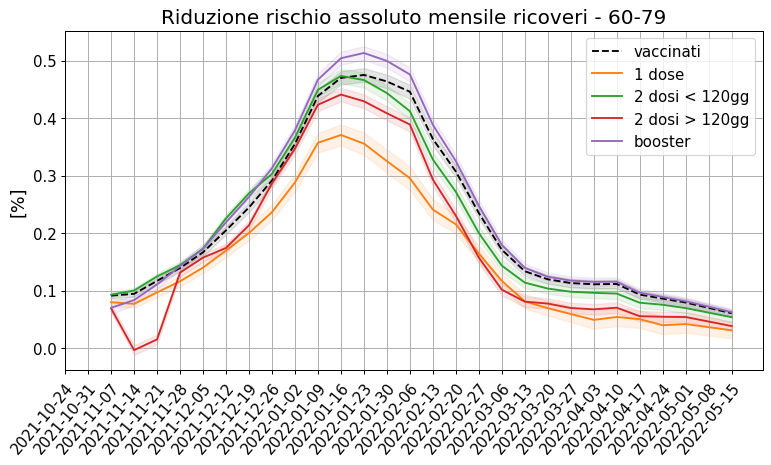

ricoveri 80+


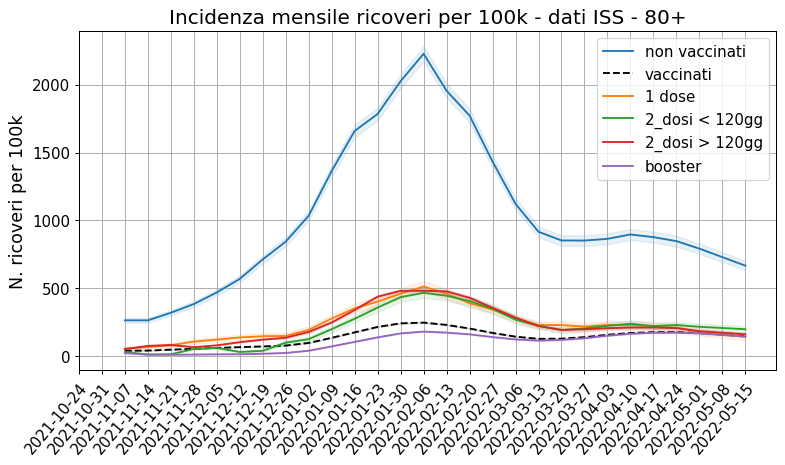

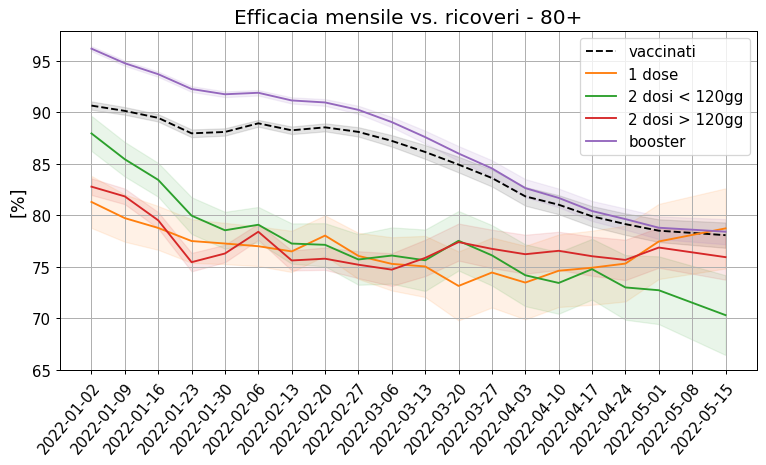

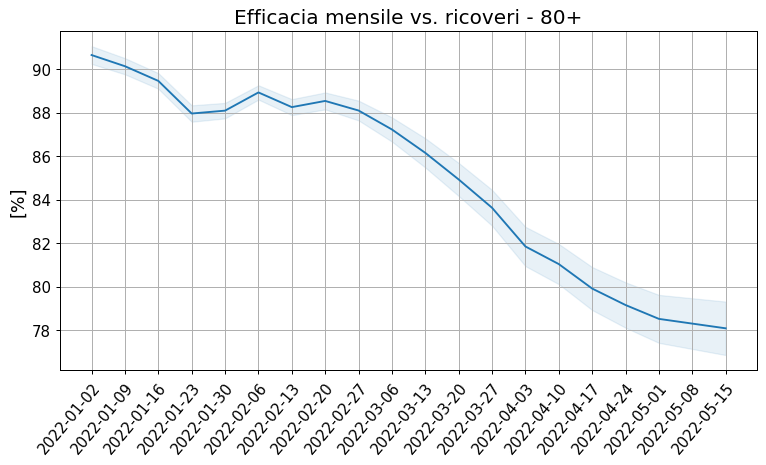

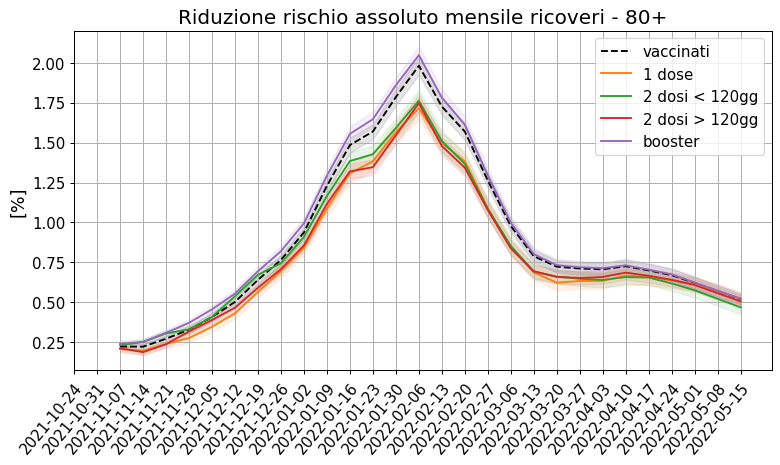

ricoveri totale


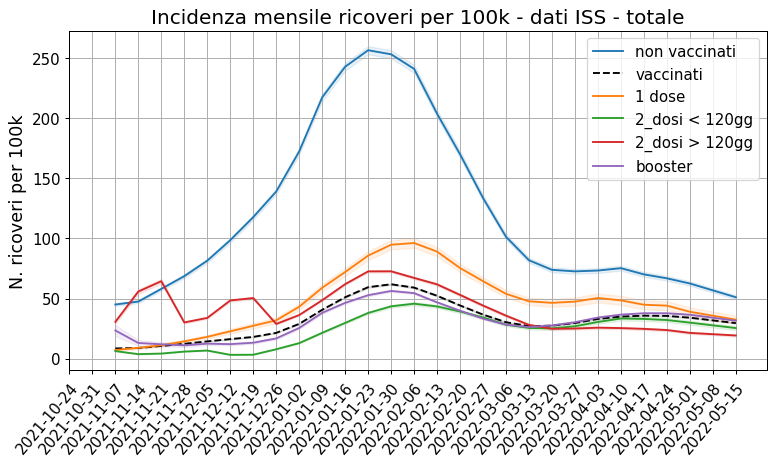

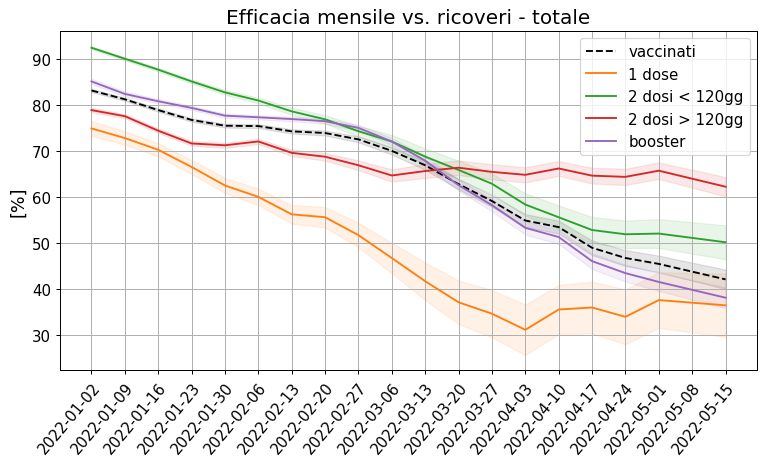

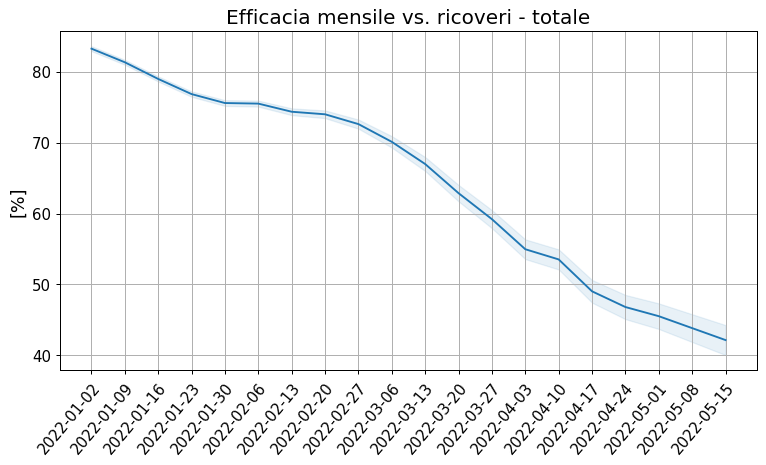

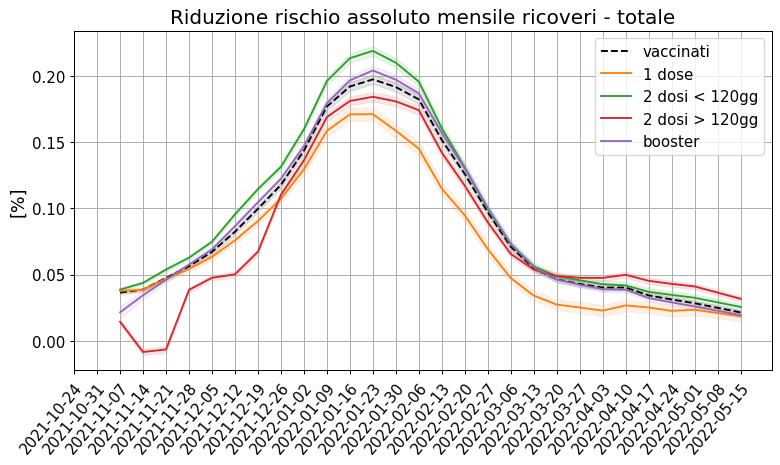

ricoveri 05-11


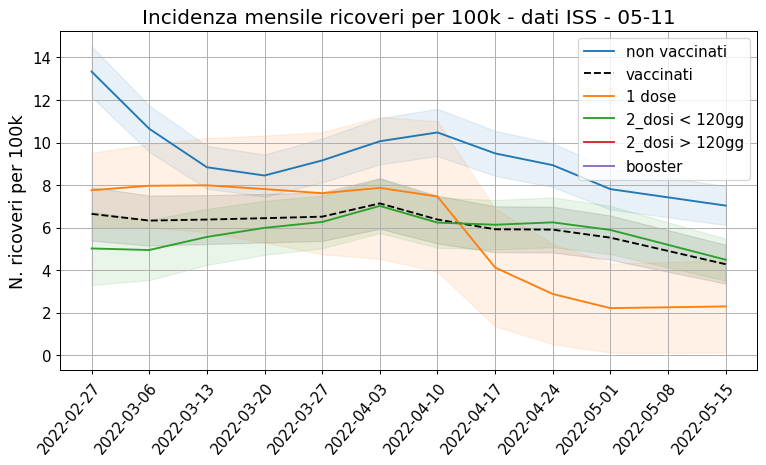

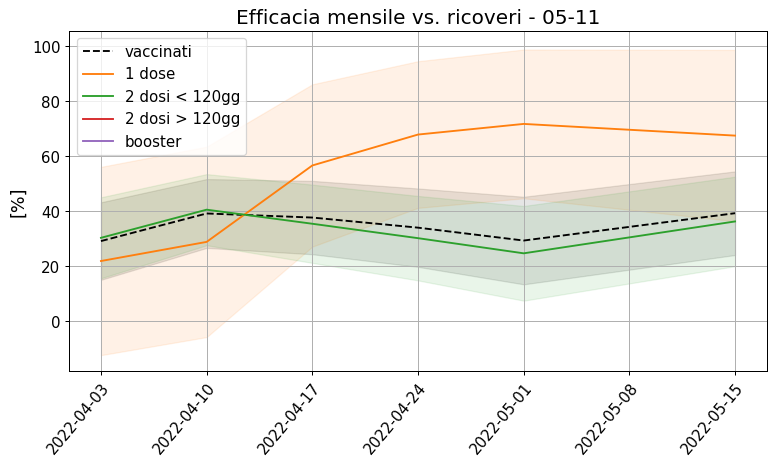

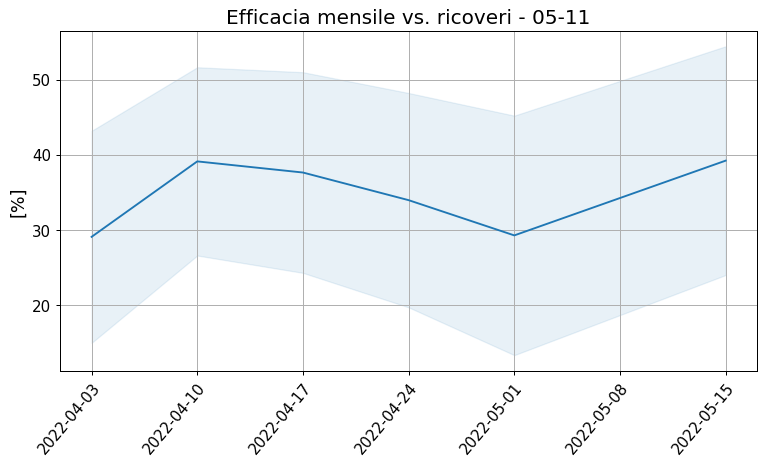

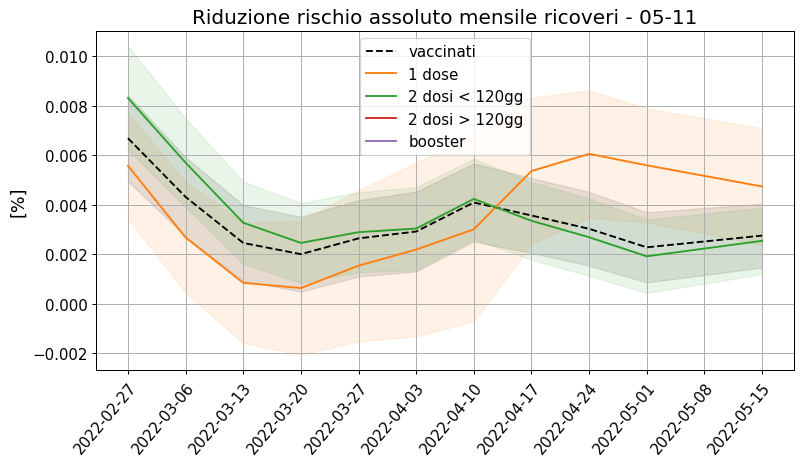

terapie_intensive 12-39


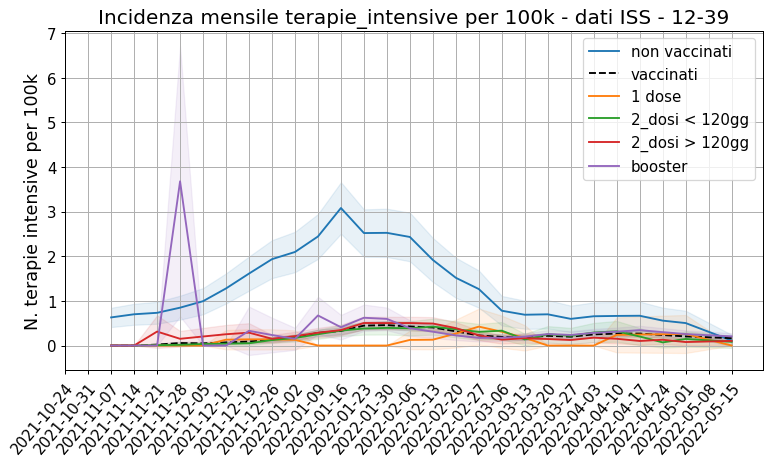

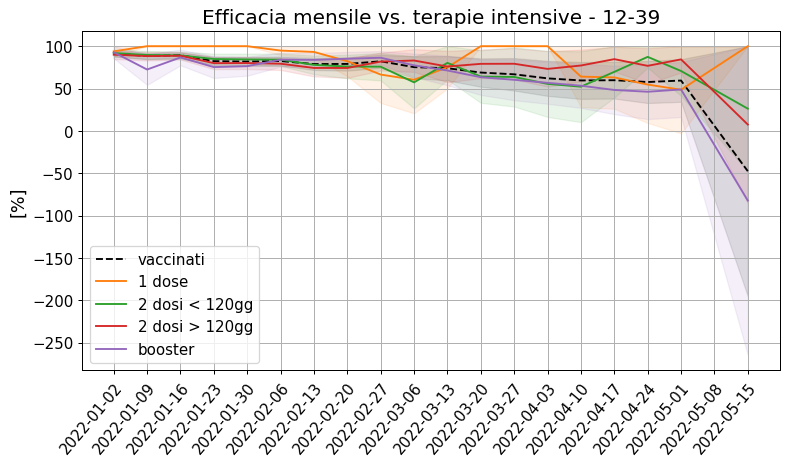

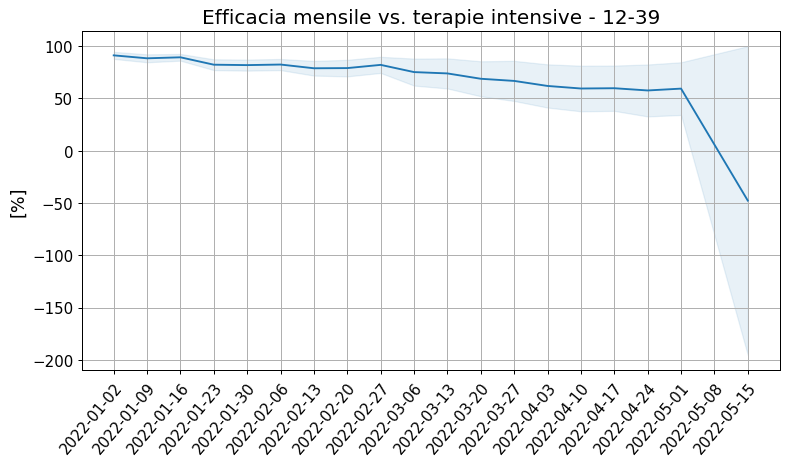

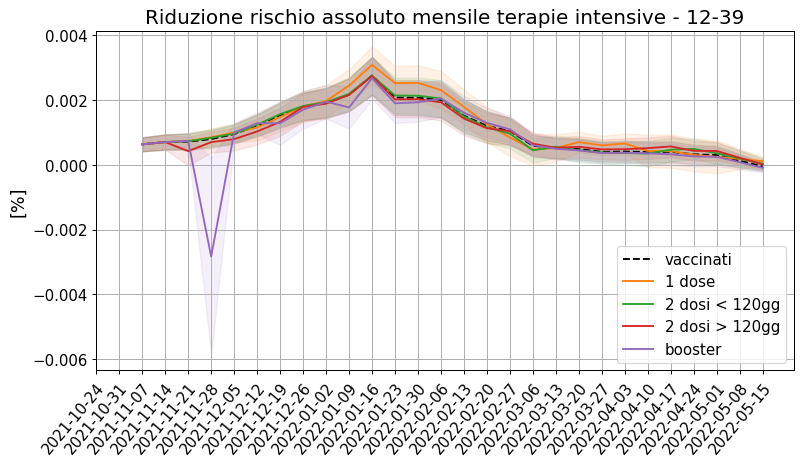

terapie_intensive 40-59


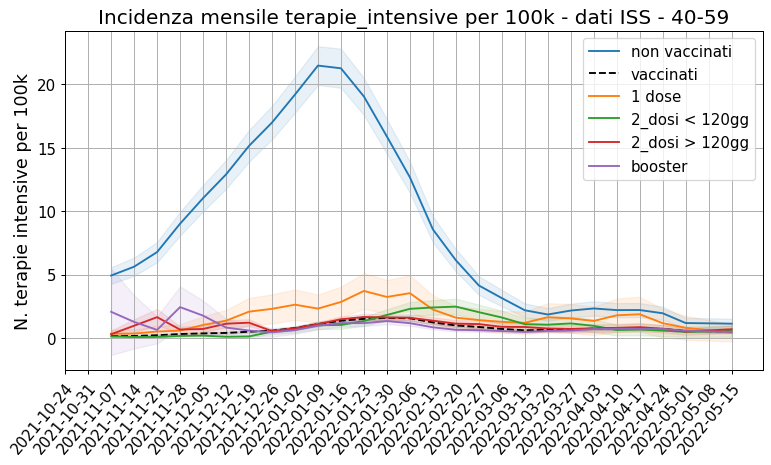

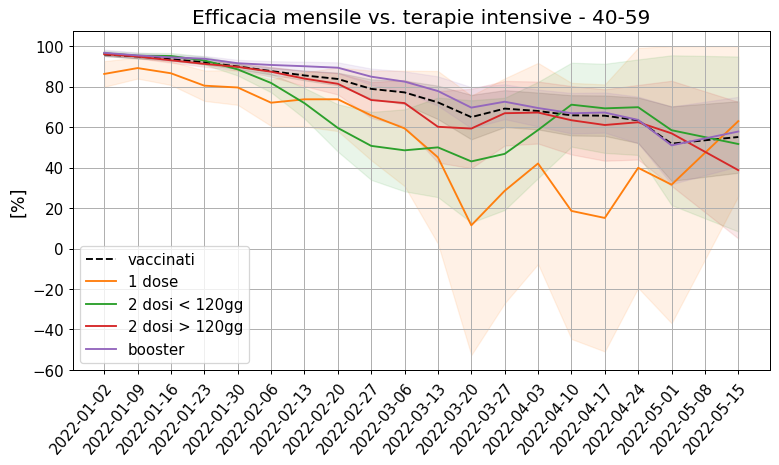

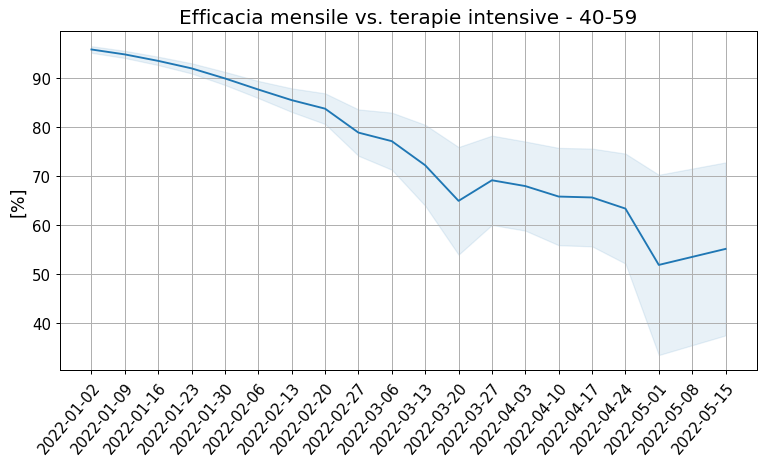

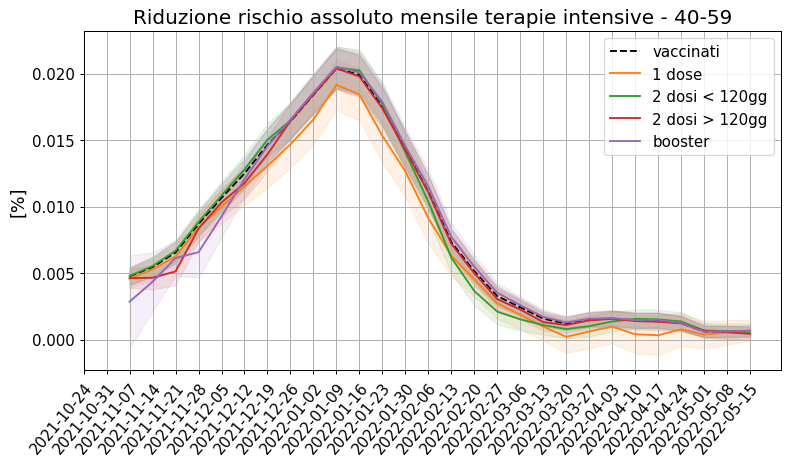

terapie_intensive 60-79


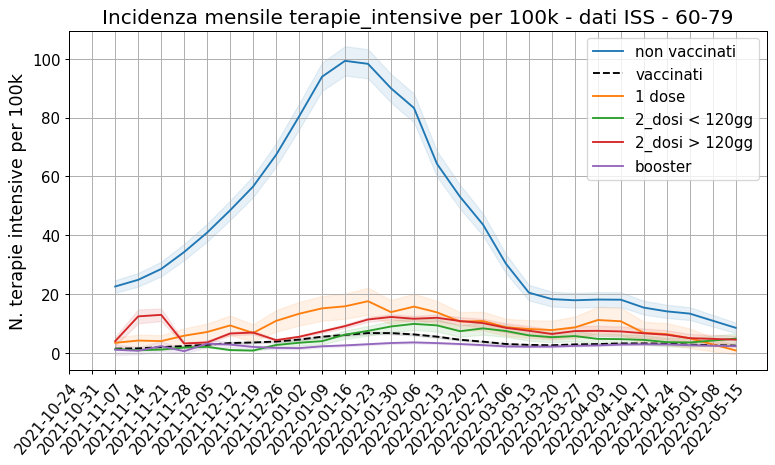

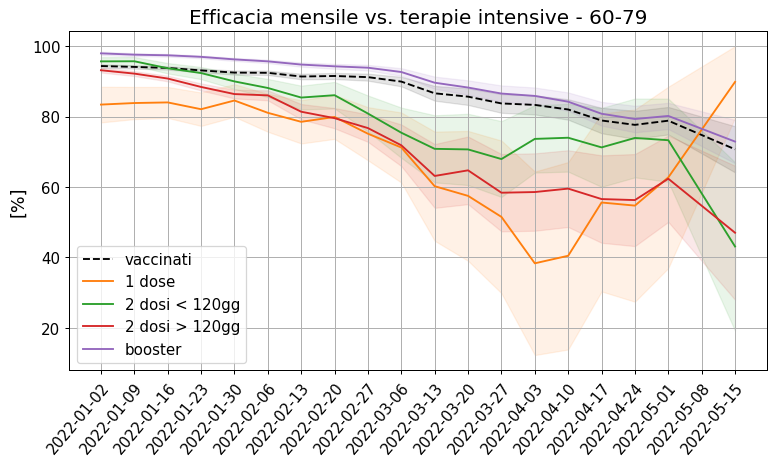

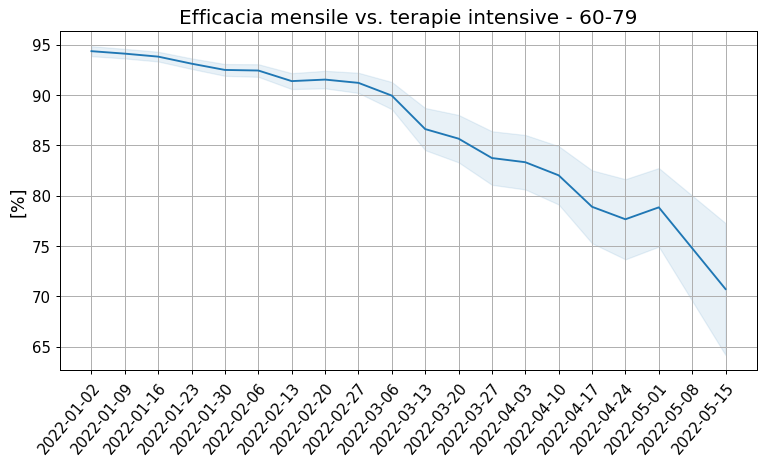

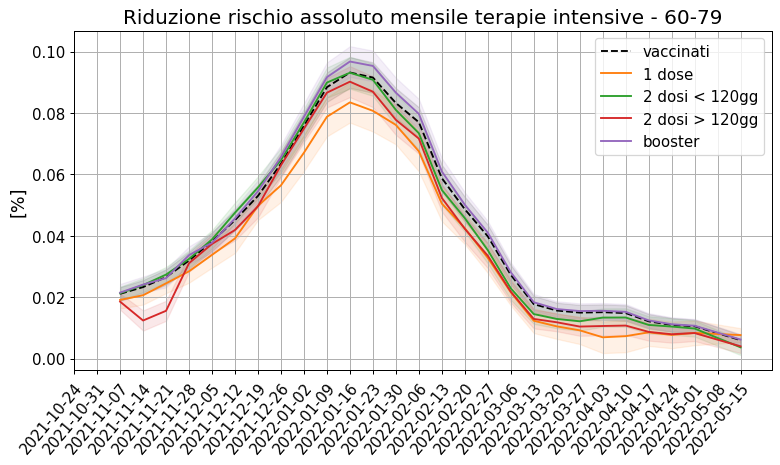

terapie_intensive 80+


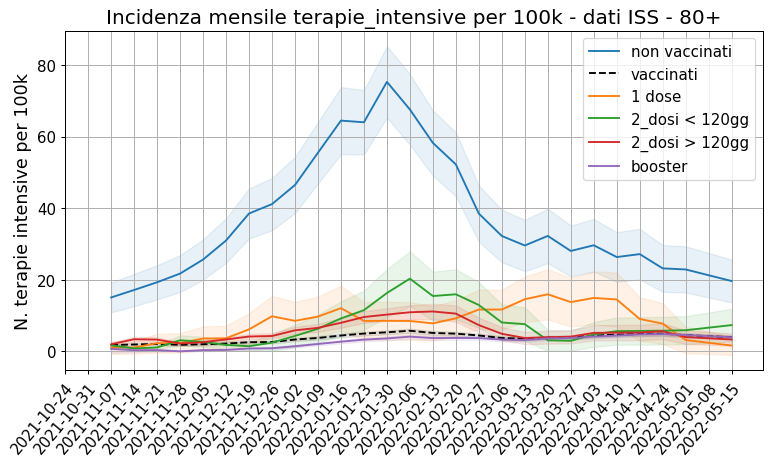

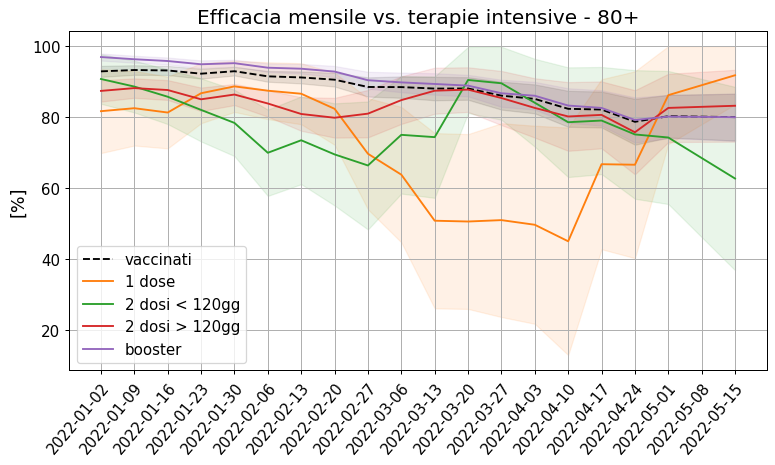

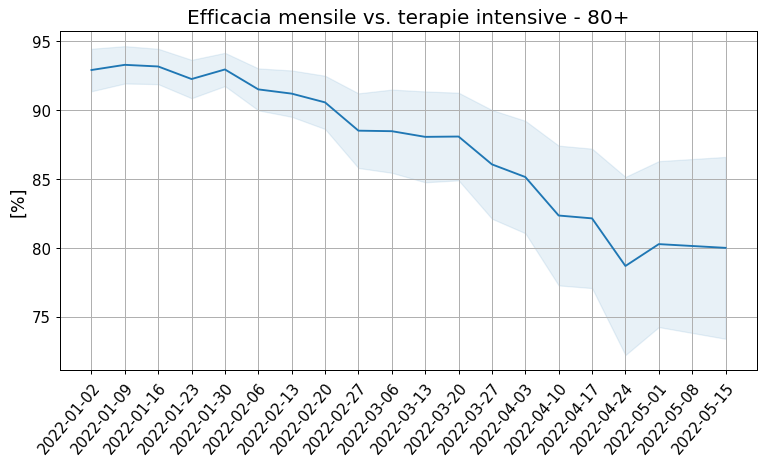

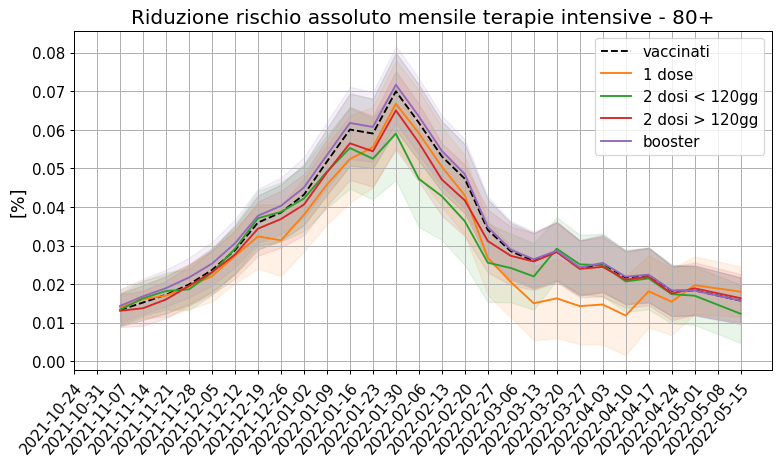

terapie_intensive totale


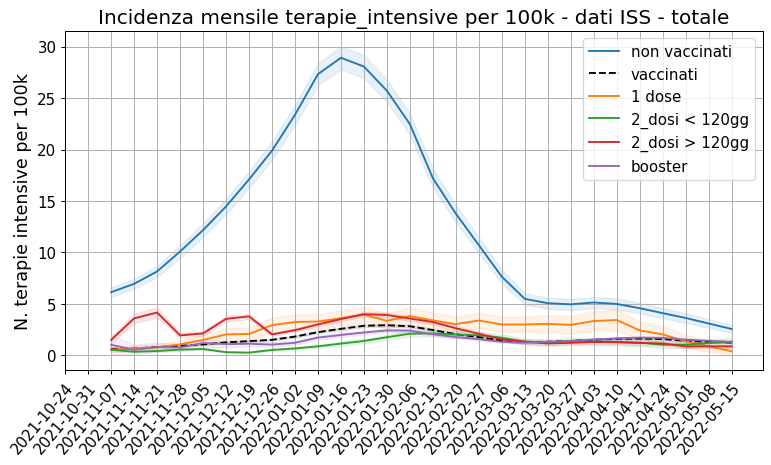

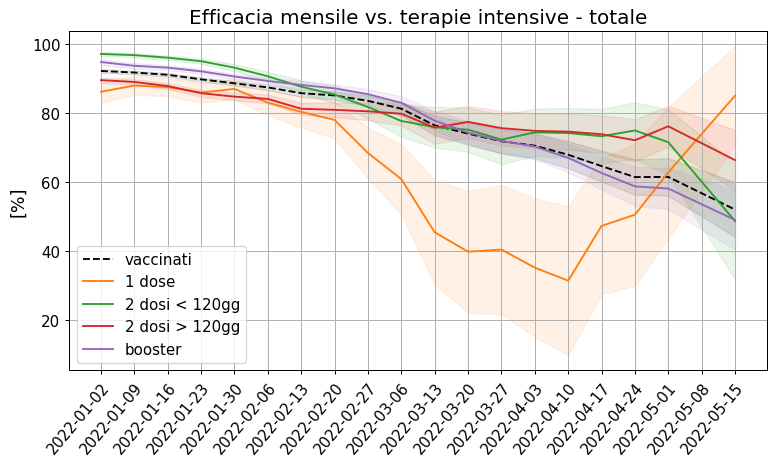

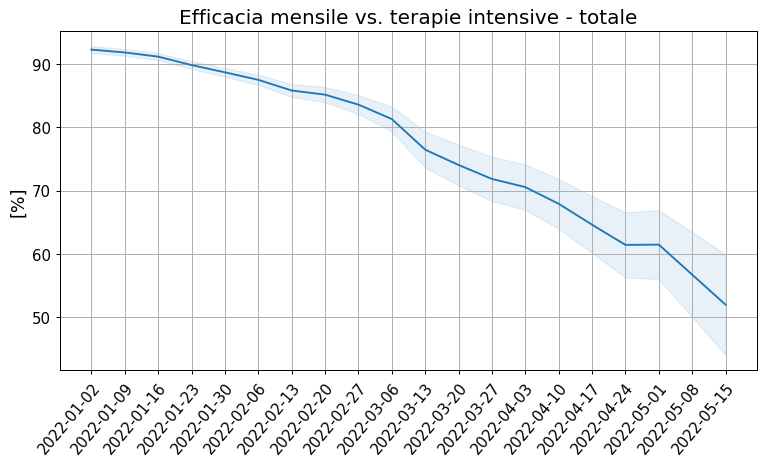

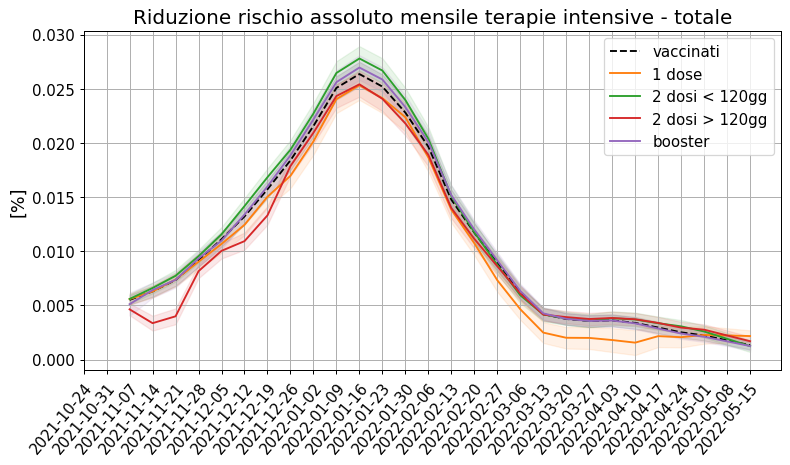

terapie_intensive 05-11


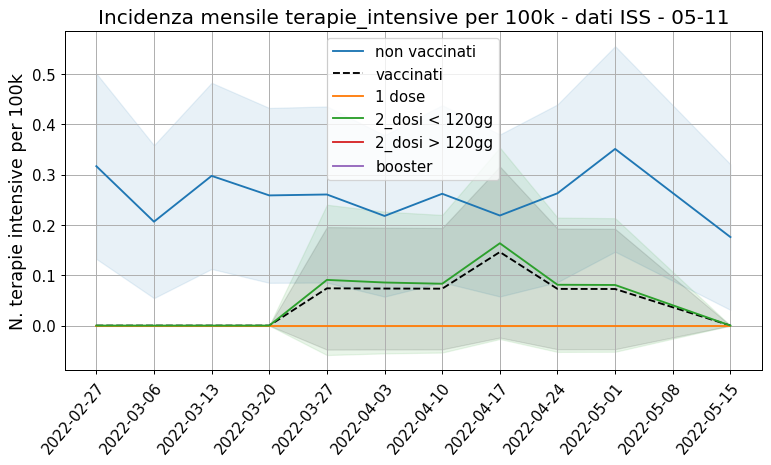

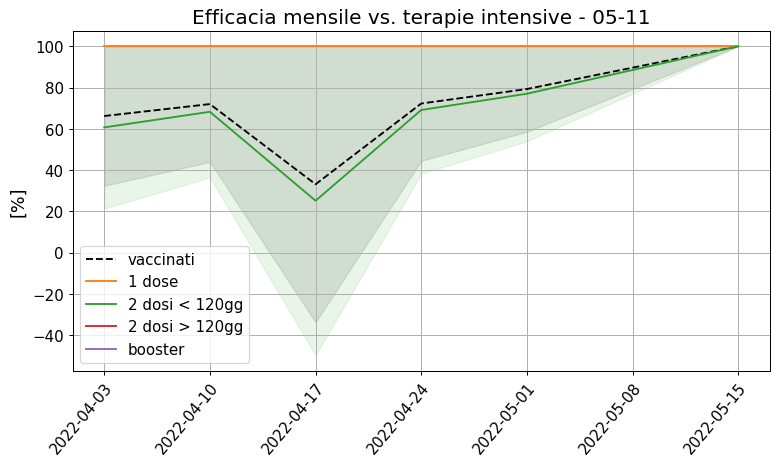

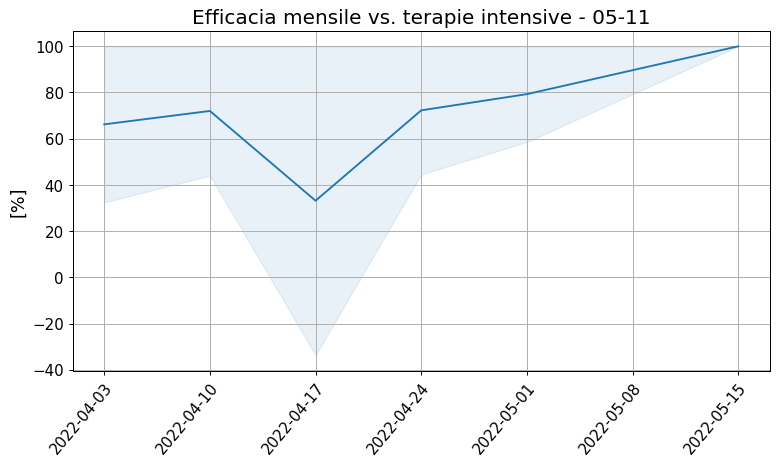

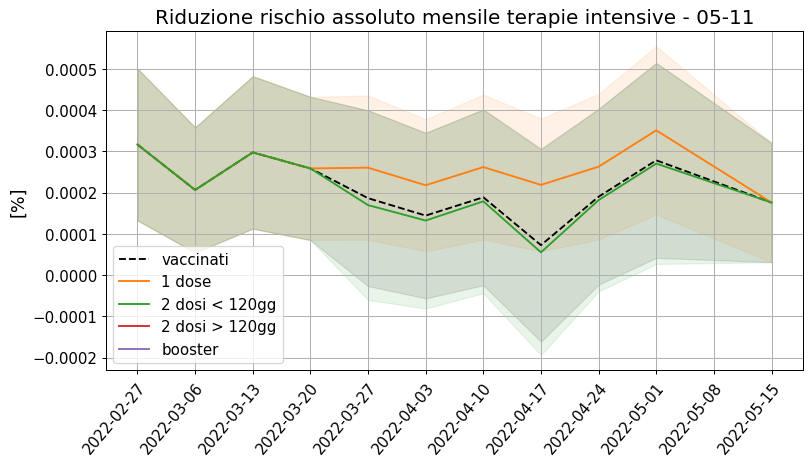

decessi 12-39


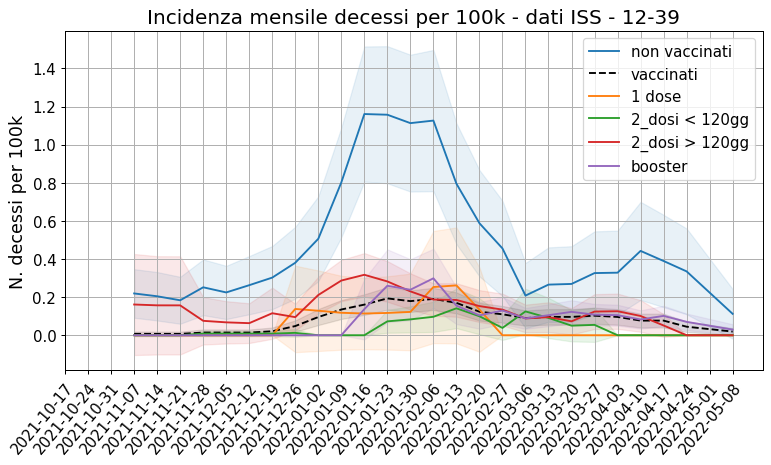

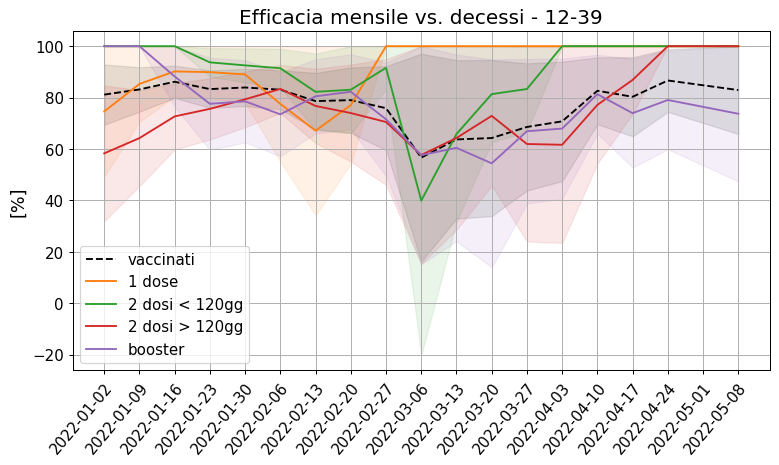

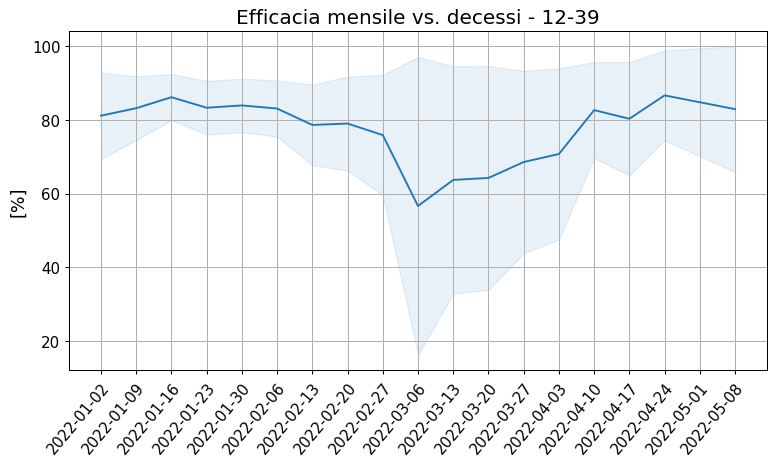

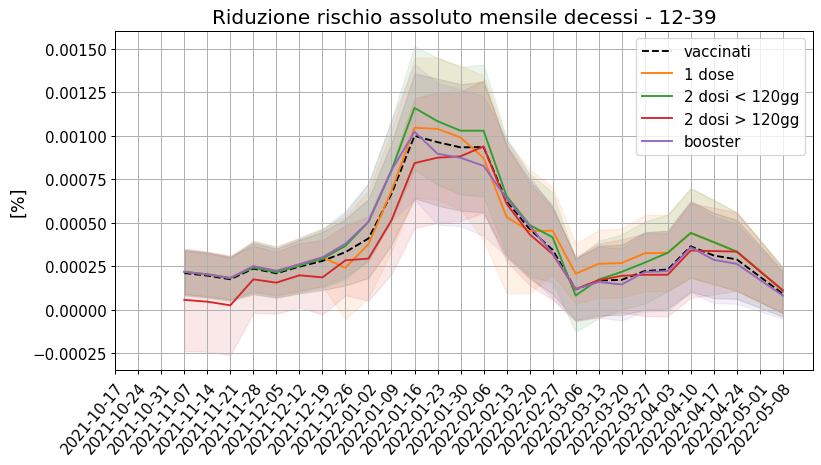

In [ ]:
for s in ["contagi","ricoveri","terapie_intensive","decessi"]:
    for eta in df_iss.fascia_eta.unique():
        
        print(s, eta)
        
        df_plt = df_iss[(df_iss.split==s) & (df_iss.fascia_eta==eta)]
        #if eta == "05-11":
        #    display(df_plt)
        #else:
        #    continue
        #df_plt = df_plt.dropna(subset=["eff_vax"])
        
        if eta == "05-11":
            start_date = "2022-04-01"
        else:
            start_date = "2022-01-01"
        
        plot_incidence(df=df_plt,
                       split=s, 
                       age=eta, 
                       colors=[COLORS[0]] + ["black"] + COLORS[1:5],
                       linestyles=["solid","dashed", "solid","solid","solid","solid"]
                      )
        
        plot_efficacy(df=df_plt, split=s, age=eta, 
                      cat=["vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut","booster"],
                      labels=["vaccinati", "1 dose", "2 dosi < 120gg", "2 dosi > 120gg", "booster"],
                      colors=["black"] + COLORS[1:5],
                      linestyles=["dashed","solid","solid","solid","solid"],
                      start_date=start_date)
        
        plot_efficacy(df=df_plt, split=s, age=eta, suffix="_all", start_date=start_date)
        
        plot_arr(df=df_plt,
                 split=s, 
                 age=eta,
                 cat=["vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut","booster"],
                 labels=["vaccinati", "1 dose", "2 dosi < 120gg", "2 dosi > 120gg", "booster"],
                 colors=["black"] + COLORS[1:5],
                 linestyles=["dashed","solid","solid","solid","solid"],
                )

In [ ]:
df_iss["no_vax_frac_err"] = 1.645*np.sqrt((df_iss["no_vax_frac"]*df_iss["vax_frac"])/(df_iss["no_vax"] + df_iss["vax"]))
df_iss["no_vax_frac_err_lo"] = df_iss["no_vax_frac"] - df_iss["no_vax_frac_err"]
df_iss["no_vax_frac_err_hi"] = df_iss["no_vax_frac"] + df_iss["no_vax_frac_err"]

In [ ]:
for age in sorted(age_values):
    plt.figure(dpi=90, figsize=(10,5))
    dates_str = []
    dates = []
    for split in ["contagi", "ricoveri", "terapie_intensive", "decessi"]:
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        dates_str += [x.strftime("%Y-%m-%d") for x in df_plt.data.unique()]
        dates += [x for x in df_plt.data.unique()]
        plt.plot(df_plt.data,
                 100*df_plt.no_vax_frac,
                 label=split.replace("_"," "),
                 linewidth=1.8
                )
        plt.fill_between(df_plt.data, 
                     100*df_plt.no_vax_frac_err_lo, 
                     100*df_plt.no_vax_frac_err_hi,
                     alpha=0.1
                    )
    title = f"Frazione non vaccinati - {age}"
    plt.title(title, fontsize=18)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("[%]",fontsize=14)
    
    dates_str = sorted(list(set(dates_str)), reverse=False)
    dates = sorted(list(set(dates)), reverse=False)
    plt.xticks(dates,
               dates_str,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right")
    plt.savefig(f"{plots_folder}/frazione_no_vax_{age}", bbox_inches="tight", facecolor="w")

In [ ]:
def plot_var_ages(split, varname="vax"):
    plt.figure(dpi=90, figsize=(10,5))
    for age in sorted(age_values):
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split=="terapie_intensive")]
        plt.plot(df_plt.data,
            df_plt[varname],
            label=age,
            linewidth=1.8)
    title = f"Totale {varname} {split}".replace("_", " ")
    plt.title(title, fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(df_plt.data,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right"
              )

In [ ]:
for age in age_values:
    if age != "totale":
        continue
    for split in splits:
        df_plt = df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        savename = f"{split}_{age}"
        yvars = ["vax", "no_vax"]
        savename += "_" + "_".join(yvars)
        createXYPlot(df_plt,
                     y=yvars,
                     x="data",
                     labels=["vaccinati", "non vaccinati"],
                     colors=["g","r"],
                     plots_folder=plots_folder,
                     linewidth=1.8,
                     days_interval=1,
                     title=f"{split} ultimi 30 giorni {age}".replace("_"," "),
                     savename=savename,
                     ytitle=f"N. {split}".replace("_"," "),
                     figsize_x=10,
                     figsize_y=5,
                     dpis=90
                    )

In [ ]:
def get_lethality(df: pd.DataFrame, 
                  age: str,
                  savename: str,
                  title: str,
                  yscale: str ="linear",
                  num_den: tuple = ("decessi","contagi"),
                 ):
    
    df_let = df[df.fascia_eta==age]
    value_cols = ["vax",
                  "no_vax",
                  "1_dose",
                  "2_dosi_lt_cut",
                  "2_dosi_gt_cut",
                  "booster",
                 ]
    df_pivot = df_let.pivot(index='data', columns=["split"], values=value_cols)
    cols = []
    for i in range(0,len(df_pivot.columns)):
        cols.append(df_pivot.columns.get_level_values(1)[i] + '_' + df_pivot.columns.get_level_values(0)[i])
    df_pivot.columns = cols
    
    for v in value_cols:
        df_pivot[f"letalita_{v}"] = df_pivot[f"{num_den[0]}_{v}"]/df_pivot[f"{num_den[1]}_{v}"]
        df_pivot[f"sd_letalita_{v}"] = np.sqrt(df_pivot[f"letalita_{v}"] * (1 - df_pivot[f"letalita_{v}"]) / df_pivot[f"contagi_{v}"])
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] - 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"hi_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] + 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"lo_err_letalita_{v}"].apply(lambda x: 0 if x < 0 else x)
    
    dates = df_pivot[[f"{num_den[0]}_no_vax",f"{num_den[1]}_no_vax"]].dropna().index
    #if age == "totale":
        #display(df_pivot[["contagi_no_vax", 
        #                  "ricoveri_no_vax", 
        #                  "letalita_no_vax",
        #                  "contagi_booster", 
        #                  "ricoveri_booster",
        #                  "letalita_booster"
        #                 ]])
        
    plt.figure(figsize=(9,5),dpi=90)
    var_dict = {"no_vax":"non vaccinati", 
                "vax":"vaccinati",
                "1_dose":"1 dose", 
                "2_dosi_lt_cut": "2 dosi < 120gg",
                "2_dosi_gt_cut": "2 dosi > 120gg",
                "booster": "booster"}
    
    color_dict = {"no_vax": COLORS[0],
                  "vax": "black",
                  "1_dose": COLORS[1],
                  "2_dosi_lt_cut": COLORS[2],
                  "2_dosi_gt_cut": COLORS[3],
                  "booster": COLORS[4]
                 }
    
    for y in var_dict.keys():
        
        lstyle="solid"
        if y == "vax":
            lstyle = "dashed"
        
        print(lstyle)
        plt.plot(df_pivot.index, 
                 100*df_pivot[f"letalita_{y}"],
                 label=var_dict[y],
                 linewidth=1.6,
                 color=color_dict[y],
                 linestyle=lstyle
                )
        plt.fill_between(df_pivot.index, 
                     100*df_pivot[f"lo_err_letalita_{y}"], 
                     100*df_pivot[f"hi_err_letalita_{y}"],
                     alpha=0.1,
                     color=color_dict[y]
    )
    plt.legend(fontsize=12)
    plt.title(f"{title} {age} - dati ISS",fontsize=17)
    plt.ylabel(f"{num_den[0]} / {num_den[1]} [%]".replace("_"," "),fontsize=14)
    _ = plt.yticks(fontsize=13)
    _ = plt.xticks(dates,
                   fontsize=13,
                   rotation=50, 
                   rotation_mode="anchor", 
                   verticalalignment = "top",
                   horizontalalignment = "right"
                  )
    plt.yscale(yscale)
    plt.savefig(f"{plots_folder}/{savename}.png", bbox_inches="tight", facecolor="w")
    return df_pivot

In [ ]:
for age in age_values:
    if age != "totale":
        continue
    get_lethality(df_iss,
                  age=age,
                  savename=f"letalita_iss_{age}",
                  title="Letalità Covid19",
                  yscale="log"
                 )

In [ ]:
for age in age_values:
    if age != 'totale':
        continue
    get_lethality(df_iss,
                  age=age,
                  savename=f"ricoveri_contagi_iss_{age}",
                  title="Tasso ricoveri su contagi Covid19",
                  yscale="log",
                  num_den=("ricoveri","contagi")
                 )

In [ ]:
for age in age_values:
    if age != "totale":
        continue
    get_lethality(df_iss,
                  age=age,
                  savename=f"terapie_intensive_contagi_iss_{age}",
                  title="Tasso terapie intensive su contagi Covid19",
                  yscale="log",
                  num_den=("terapie_intensive","contagi"))

In [ ]:
df_iss["no_vax_last7"] = df_iss["no_vax"] - df_iss.groupby(["fascia_eta","split"])["no_vax"].shift(1)
df_iss["vax_last7"] = df_iss["vax"] - df_iss.groupby(["fascia_eta","split"])["vax"].shift(1)

In [ ]:
for split in ["contagi", "ricoveri", "terapie_intensive", "decessi"]:
    df_plt = df_iss[(df_iss.fascia_eta=="totale") & (df_iss.split==split)].reset_index()
    createXYPlot(df_plt,
             bar=True,
             bar_start=[-0.5, 0.5],
             alphas=[0.8,0.8],
             bar_width=0.3,
             x="data",
             y=["no_vax_last7","vax_last7"],
             labels=["non vaccinati", "vaccinati"],
             colors=["red","green"],
             linewidth=1.7,
             days_interval=1,
             plots_folder=plots_folder,
             title=f"variazione {split} mensili - ultimi 7 giorni - dati ISS".replace("_"," "),
             savename=f"{split}_ultimi7")

In [ ]:
df_pop

In [ ]:
df_pop_pivot = df_pop.pivot(index=["data_pop"],columns=["fascia_eta"]).reset_index()

In [ ]:
new_col_names = [x[0] + x[1] for x in df_pop_pivot.columns]

In [ ]:
df_pop_pivot.columns = df_pop_pivot.columns.droplevel(0)

In [ ]:
df_pop_pivot.columns = new_col_names

In [ ]:
df_pop_pivot

In [ ]:
from dateutil.relativedelta import relativedelta
path = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df_daily = getVariables(pd.read_csv(path))


df_daily["data"] = pd.to_datetime(df_daily["data"])
df_daily["data"] = df_daily["data"].apply(lambda x: x.date())
df_daily["data_prev"] = pd.to_datetime("2021-12-10")

In [ ]:
df_test = df_daily[(df_daily.data > datetime.strptime("2021-12-10","%Y-%m-%d").date()) & 
         (df_daily.data < datetime.strptime("2022-01-09","%Y-%m-%d").date())][["data","dow","nuovi_positivi"]]

In [ ]:
np.sum(df_test["nuovi_positivi"])

In [ ]:
np.sum(df_contagi[df_contagi.fascia_eta=="totale"][["vax","no_vax"]],axis=1)

In [ ]:
for v in ["ingressi_terapia_intensiva", "nuovi_positivi"]:
    df_daily[f"{v}_last_month"] = df_daily.apply(lambda x: df_daily.loc[(df_daily.data >= x.data_prev) & 
                                                                 (df_daily.data < x.data), v].sum(), axis=1)


In [ ]:
df_ti_comp      = df_ti[df_ti.fascia_eta=="totale"][["data","vax","no_vax"]]
df_contagi_comp = df_contagi[df_contagi.fascia_eta=="totale"][["data","vax","no_vax"]]

df_ti_comp["data"] = pd.to_datetime(df_ti_comp["data"]).apply(lambda x: x.date())
df_contagi_comp["data"] = pd.to_datetime(df_contagi_comp["data"]).apply(lambda x: x.date())

df_daily_comp = df_daily[["data","ingressi_terapia_intensiva_last_month","nuovi_positivi_last_month"]]

In [ ]:
df_comp_contagi = df_daily_comp.merge(df_contagi_comp, on="data", how="inner")
df_comp_contagi["tot"] = df_comp_contagi["vax"] + df_comp_contagi["no_vax"]
df_comp_contagi["diff"] = df_comp_contagi["tot"] - df_comp_contagi["nuovi_positivi_last_month"] 

In [ ]:
df_comp_contagi[["data","nuovi_positivi_last_month","tot","diff"]]

In [ ]:
df_comp = df_daily_comp.merge(df_ti_comp, on="data", how="inner")
df_comp["tot"] = df_comp["vax"] + df_comp["no_vax"]
df_comp["diff"] = df_comp["tot"] - df_comp["ingressi_terapia_intensiva_last_month"] 

In [ ]:
createXYPlot(df_comp,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Terapie Intensive)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

In [ ]:
createXYPlot(df_comp_contagi,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Contagi)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

In [ ]:
df_comp_contagi

In [ ]:
import pandas as pd
pd.read_csv("https://data.gov.il/dataset/covid-19/resource/8a51c65b-f95a-4fb8-bd97-65f47109f41f/download/event-among-vaccinated-126.csv")